In [ ]:
# !pip install seaborn==0.11.2
# !pip uninstall theano
# !pip install arviz
# !pip install pymc3
# !pip install theano-pymc
# !pip install numpy scipy pandas
# !pip install sklearn graphviz
# !pip install "jax[cpu]==0.3.14" -f https://whls.blob.core.windows.net/unstable/index.html --use-deprecated legacy-resolver
# !pip install numpyro==0.10.0

In [ ]:
!pip install arviz
!pip install numpyro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 6.6 MB/s eta 0:00:00


In [ ]:
# import sys
# print(sys.path)

In [ ]:
# import pkg_resources as pkg
# pkg.require("seaborn==0.11.2")
# pkg.require("numpy==1.22.1")

import math
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, FixedLocator
from matplotlib import rc

import jax.numpy as jnp
from jax import nn, random, vmap
from jax.scipy.special import expit

import numpyro as npr
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, Predictive, SVI, Trace_ELBO, log_likelihood
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro import sample, deterministic
from numpyro.distributions.transforms import OrderedTransform

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)

npr.set_platform("cpu")
npr.set_host_device_count(10)
npr.enable_x64()

print('Running on Numpyro v{}'.format(npr.__version__))
print('Running on Seaborn v{}'.format(sns.__version__))

from IPython.display import Image

# color = '#87CEEB'
# initialize_plt_font()


RANDOM_SEED = 9876

Running on Numpyro v0.18.0
Running on Seaborn v0.13.2


In [ ]:
# color definitions
base_color = "#1696D2"
accent_color = "#FCB918"
neutral_gray= "#C6C6C6"
green_color = '#186b2b'
yellow_color = '#dea228'

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-white")
az.rcParams["stats.hdi_prob"] = 0.89
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "loo"


pd.set_option('display.max_rows', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# If it is run on Colab, put the exp1_data folder in the root of your Google drive and use this data path
DATA_PATH = "drive/My Drive/QV_data"
OUTPUT_PATH = "drive/My Drive/QV_data/Output/Sign"
MODEL_PATH = "drive/My Drive/QV_data/Model"
# If it is run on a local machine, use the following data path
# DATA_PATH = "exp1_data"
# MODEL_PATH = "models"
# OUTPUT_PATH = "output"

Mounted at /content/drive


In [ ]:
from tqdm.autonotebook import tqdm

## Import Data

### Likert Data

In [ ]:
likert_raw = pd.read_csv(os.path.join(DATA_PATH, 'exp1_data', 'ALLOCATE_LIKERT_P1.csv')).sort_values(by=['userId'])
print(likert_raw.shape)
likert_raw.head()

(56, 14)


,_id,pets,art,education,environment,health,human,international,faith,veteran,data_reason_likert_p1,time,userId,order
0,5e62bd916ffda4487364f749,3,3,5,5,5,5,4,2,4,I chose societal issues that have a direct imp...,16:01.8,5e62bc5def25df51135385a3,first
1,5e62cf03ef25df51135385b7,4,2,5,3,4,5,4,4,5,I think people over other things take priority.,30:27.7,5e62ceb06ffda4487364f75b,first
2,5e62d0e16ffda4487364f75e,4,4,5,5,5,5,3,3,4,I made these decisions based on what topics I ...,38:25.5,5e62cfd5ef25df51135385b9,first
3,5e6410c2ae7e33fbc93cdd0d,3,3,4,4,5,3,3,1,4,I want most of the money to go towards health-...,23:15.0,5e641008789957f84988d12b,first
4,5e641563789957f84988d143,5,5,5,5,5,5,5,5,5,All these issues are important. It’s all part...,42:59.7,5e641507ae7e33fbc93cdd19,first


In [ ]:
likert_d_raw = pd.read_csv(os.path.join(DATA_PATH, 'exp1_data', 'DONATION_LIKERT.csv')).sort_values(by=['userId'])
likert_d_raw.head()

,_id,donation_a_pets,donation_b_art,donation_c_education,donation_d_environment,donation_e_health,donation_f_human,donation_g_international,donation_h_faith,donation_i_veteran,time,userId
0,5e62bf3aef25df51135385a6,0,0,12,0,12,11,0,0,0,23:06.2,5e62bc5def25df51135385a3
1,5e62cf4b6ffda4487364f75c,0,0,0,0,0,0,0,0,0,31:39.6,5e62ceb06ffda4487364f75b
2,5e62d1ba6ffda4487364f75f,0,0,0,5,5,5,0,0,0,42:02.1,5e62cfd5ef25df51135385b9
3,5e6411a9789957f84988d134,0,0,0,10,10,5,0,0,10,27:05.8,5e641008789957f84988d12b
4,5e641593789957f84988d144,0,0,0,0,0,0,0,0,0,43:47.2,5e641507ae7e33fbc93cdd19


### QV Data

In [ ]:
qv36_raw = pd.read_csv(os.path.join(DATA_PATH, 'exp1_data', 'QV_P1_36.csv')).sort_values(by=['userId'])
print(qv36_raw.shape)
qv36_raw.head()

(107, 14)


,_id,pets,art,education,environment,health,human,international,faith,veteran,userId,time,completed,order
0,5e62c631ef25df51135385ae,2,0,0,5,1,2,0,0,1,5e62c4156ffda4487364f751,52:49.9,5e62c4156ffda4487364f751,first
1,5e63ff50b7375d865ecb6e5e,2,1,3,2,2,3,1,1,1,5e63fde404f53cb40efd2cdb,08:48.9,5e63fde404f53cb40efd2cdb,first
2,5e641244789957f84988d13f,1,1,0,3,2,2,2,-3,-2,5e640f2eae7e33fbc93cdd09,29:41.0,5e640f2eae7e33fbc93cdd09,decrease
3,5e6411c4789957f84988d137,1,2,2,1,3,4,1,0,0,5e640f66ae7e33fbc93cdd0b,27:32.6,5e640f66ae7e33fbc93cdd0b,decrease
4,5e6417c1789957f84988d147,1,1,3,2,3,3,1,0,1,5e64113fae7e33fbc93cdd10,53:05.3,5e64113fae7e33fbc93cdd10,decrease


In [ ]:
qv36_d_raw = pd.read_csv(os.path.join(DATA_PATH, 'exp1_data', 'DONATION_QV36.csv')).sort_values(by=['userId'])
print(qv36_d_raw.shape)
qv36_d_raw.head()

(107, 13)


,_id,donation_a_pets,donation_b_art,donation_c_education,donation_d_environment,donation_e_health,donation_f_human,donation_g_international,donation_h_faith,donation_i_veteran,time,userId,isQV
0,5e62c70def25df51135385af,0,0,0,5,0,0,0,0,0,56:29.8,5e62c4156ffda4487364f751,1
1,5e63ffdbb7375d865ecb6e5f,0,0,0,0,0,0,0,0,0,11:07.8,5e63fde404f53cb40efd2cdb,1
2,5e641352789957f84988d141,0,0,0,0,0,5,5,0,0,34:10.4,5e640f2eae7e33fbc93cdd09,2
3,5e6411fa789957f84988d13c,0,0,0,0,0,0,0,0,0,28:26.6,5e640f66ae7e33fbc93cdd0b,2
4,5e641842789957f84988d149,10,0,0,10,10,0,0,0,5,55:14.3,5e64113fae7e33fbc93cdd10,2


In [ ]:
qv108_raw = pd.read_csv(os.path.join(DATA_PATH, 'exp1_data', 'QV_P1_108.csv')).sort_values(by=['userId'])
qv108_raw.head()

,_id,pets,art,education,environment,health,human,international,faith,veteran,userId,time,completed,order
0,5e62ccb26ffda4487364f759,2,1,2,2,2,-8,-4,2,2,5e62c99c6ffda4487364f757,20:34.1,5e62c99c6ffda4487364f757,decrease
1,5e62d6c9ef25df51135385be,4,0,4,1,6,3,0,4,3,5e62d3746ffda4487364f760,03:37.4,5e62d3746ffda4487364f760,first
2,5e636639169182538ed7dc65,3,3,5,5,3,3,1,0,4,5e6363eaab9c7a51ed5b57e2,15:37.8,5e6363eaab9c7a51ed5b57e2,first
3,5e63ff8304f53cb40efd2cdd,3,2,5,2,2,5,2,3,2,5e63fde404f53cb40efd2cdb,09:39.9,5e63fde404f53cb40efd2cdb,increase
4,5e641183ae7e33fbc93cdd12,2,3,3,2,4,8,1,0,0,5e640f66ae7e33fbc93cdd0b,26:27.5,5e640f66ae7e33fbc93cdd0b,first


In [ ]:
qv108_d_raw = pd.read_csv(os.path.join(DATA_PATH, 'exp1_data', 'DONATION_QV108.csv')).sort_values(by=['userId'])
qv108_d_raw.head()

,_id,donation_a_pets,donation_b_art,donation_c_education,donation_d_environment,donation_e_health,donation_f_human,donation_g_international,donation_h_faith,donation_i_veteran,time,userId,isQV,Unnamed: 13
0,5e62cde36ffda4487364f75a,10,0,0,0,0,0,0,5,5,25:39.2,5e62c99c6ffda4487364f757,2,5e62c99c6ffda4487364f757
1,5e62d7fdef25df51135385bf,2,0,0,0,5,5,0,0,5,08:45.6,5e62d3746ffda4487364f760,1,5e62d3746ffda4487364f760
2,5e636716ab9c7a51ed5b57e6,3,1,10,15,2,2,0,0,2,19:18.7,5e6363eaab9c7a51ed5b57e2,1,5e6363eaab9c7a51ed5b57e2
3,5e63ffdbb7375d865ecb6e5f,0,0,0,0,0,0,0,0,0,11:07.8,5e63fde404f53cb40efd2cdb,2,5e63fde404f53cb40efd2cdb
4,5e6411fa789957f84988d13c,0,0,0,0,0,0,0,0,0,28:26.6,5e640f66ae7e33fbc93cdd0b,1,5e640f66ae7e33fbc93cdd0b


In [ ]:
qv324_raw = pd.read_csv(os.path.join(DATA_PATH, 'exp1_data', 'QV_P1_324.csv')).sort_values(by=['userId'])
qv324_raw.head()

,_id,pets,art,education,environment,health,human,international,faith,veteran,userId,time,completed,order
0,5e62c6856ffda4487364f755,5,2,3,13,6,5,6,0,4,5e62c4156ffda4487364f751,54:13.6,5e62c4156ffda4487364f751,increase
1,5e62cc696ffda4487364f758,7,3,3,2,3,-12,-5,3,4,5e62c99c6ffda4487364f757,19:21.1,5e62c99c6ffda4487364f757,first
2,5e62d7496ffda4487364f763,6,0,7,3,12,4,0,5,6,5e62d3746ffda4487364f760,05:45.1,5e62d3746ffda4487364f760,increase
3,5e63669a169182538ed7dc66,5,5,9,9,7,4,3,0,5,5e6363eaab9c7a51ed5b57e2,17:14.3,5e6363eaab9c7a51ed5b57e2,increase
4,5e6411e9789957f84988d139,5,6,4,7,7,6,5,-7,-4,5e640f2eae7e33fbc93cdd09,28:09.9,5e640f2eae7e33fbc93cdd09,first


In [ ]:
qv324_d_raw = pd.read_csv(os.path.join(DATA_PATH, 'exp1_data', 'DONATION_QV324.csv')).sort_values(by=['userId'])
print(qv324_d_raw.shape)
qv324_d_raw.head()

(111, 14)


,_id,donation_a_pets,donation_b_art,donation_c_education,donation_d_environment,donation_e_health,donation_f_human,donation_g_international,donation_h_faith,donation_i_veteran,time,userId,isQV,Unnamed: 13
0,5e62c70def25df51135385af,0,0,0,5,0,0,0,0,0,56:29.8,5e62c4156ffda4487364f751,2,5e62c4156ffda4487364f751
1,5e62cde36ffda4487364f75a,10,0,0,0,0,0,0,5,5,25:39.2,5e62c99c6ffda4487364f757,1,5e62c99c6ffda4487364f757
2,5e62d7fdef25df51135385bf,2,0,0,0,5,5,0,0,5,08:45.6,5e62d3746ffda4487364f760,2,5e62d3746ffda4487364f760
3,5e636716ab9c7a51ed5b57e6,3,1,10,15,2,2,0,0,2,19:18.7,5e6363eaab9c7a51ed5b57e2,2,5e6363eaab9c7a51ed5b57e2
4,5e641352789957f84988d141,0,0,0,0,0,5,5,0,0,34:10.4,5e640f2eae7e33fbc93cdd09,1,5e640f2eae7e33fbc93cdd09


### Linear QV Data

In [ ]:
lqv36_raw = pd.read_csv(os.path.join(DATA_PATH, 'linearQV_rerun_data', 'LinearQV_36.csv')).sort_values(by=['userId'])
print(lqv36_raw.shape)
lqv36_raw.head()

(105, 11)


,userId,pets,art,education,environment,health,human,international,faith,veteran,order
0,62ded8f8ff378df9a0d3080c,4,3,6,3,2,0,0,0,0,first
1,62dedc47d1827047a2042384,2,2,3,3,2,3,1,1,1,first
2,62dedd20d1827047a2042386,0,1,2,6,3,5,1,0,0,decrease
3,62dee339ff378df9a0d3081b,2,3,8,1,2,1,0,1,0,decrease
4,62dee4a6d1827047a204239c,1,1,4,5,4,1,0,-1,1,decrease


In [ ]:
lqv36_d_raw = pd.read_csv(os.path.join(DATA_PATH, 'linearQV_rerun_data', 'LinearQV_36_Donation.csv')).sort_values(by=['userId'])
print(lqv36_d_raw.shape)
lqv36_d_raw.head()

(105, 10)


,userId,donation_g_international,donation_e_health,donation_c_education,donation_d_environment,donation_f_human,donation_a_pets,donation_b_art,donation_i_veteran,donation_h_faith
0,62ded8f8ff378df9a0d3080c,3,2,4,2,1,3,2,1,1
1,62dedc47d1827047a2042384,0,0,0,0,0,0,0,0,0
2,62dedd20d1827047a2042386,0,0,0,5,0,0,0,0,0
3,62dee339ff378df9a0d3081b,10,5,0,0,10,5,0,0,5
4,62dee4a6d1827047a204239c,1,1,1,1,1,1,1,0,0


In [ ]:
lqv108_raw = pd.read_csv(os.path.join(DATA_PATH, 'linearQV_rerun_data', 'LinearQV_108.csv')).sort_values(by=['userId'])
print(lqv108_raw.shape)
lqv108_raw.head()

(108, 11)


,userId,pets,art,education,environment,health,human,international,faith,veteran,order
0,62dee2f5d1827047a2042395,11,5,22,7,6,2,0,0,1,first
1,62dee4a6d1827047a204239c,5,5,8,6,13,4,2,-10,1,first
2,62def0f9d1827047a20423b1,14,9,5,5,7,7,2,5,0,first
3,62def631d1827047a20423b9,14,9,9,7,12,3,0,0,0,first
4,62df8d7e6181cc219f31a139,17,9,15,5,4,3,1,0,0,first


In [ ]:
lqv108_d_raw = pd.read_csv(os.path.join(DATA_PATH, 'linearQV_rerun_data', 'LinearQV_108_Donation.csv')).sort_values(by=['userId'])
print(lqv108_d_raw.shape)
lqv108_d_raw.head()

(108, 10)


,userId,donation_g_international,donation_e_health,donation_c_education,donation_d_environment,donation_f_human,donation_a_pets,donation_b_art,donation_i_veteran,donation_h_faith
0,62dee2f5d1827047a2042395,0,2,5,0,3,2,0,5,0
1,62dee4a6d1827047a204239c,0,1,1,0,1,1,1,1,1
2,62def0f9d1827047a20423b1,5,5,0,5,5,5,5,0,5
3,62def631d1827047a20423b9,4,1,2,7,2,2,5,9,3
4,62df8d7e6181cc219f31a139,4,2,6,5,2,3,3,5,5


In [ ]:
lqv324_raw = pd.read_csv(os.path.join(DATA_PATH, 'linearQV_rerun_data', 'LinearQV_324.csv')).sort_values(by=['userId'])
print(lqv324_raw.shape)
lqv324_raw.head()

(101, 11)


,userId,pets,art,education,environment,health,human,international,faith,veteran,order
0,62ded8f8ff378df9a0d3080c,3,4,23,18,13,19,11,-2,54,increase
1,62dedc47d1827047a2042384,2,2,1,0,1,1,-1,-1,1,increase
2,62dedd20d1827047a2042386,5,10,20,42,25,35,10,5,10,first
3,62dee2f5d1827047a2042395,27,13,39,28,35,9,7,0,4,increase
4,62dee339ff378df9a0d3081b,13,21,32,22,31,19,13,8,3,first


In [ ]:
lqv324_d_raw = pd.read_csv(os.path.join(DATA_PATH, 'linearQV_rerun_data', 'LinearQV_324_Donation.csv')).sort_values(by=['userId'])
print(lqv324_d_raw.shape)
lqv324_d_raw.head()

(101, 10)


,userId,donation_g_international,donation_e_health,donation_c_education,donation_d_environment,donation_f_human,donation_a_pets,donation_b_art,donation_i_veteran,donation_h_faith
0,62ded8f8ff378df9a0d3080c,3,2,4,2,1,3,2,1,1
1,62dedc47d1827047a2042384,0,0,0,0,0,0,0,0,0
2,62dedd20d1827047a2042386,0,0,0,5,0,0,0,0,0
3,62dee2f5d1827047a2042395,3,5,5,2,2,0,0,0,0
4,62dee339ff378df9a0d3081b,10,5,0,0,10,5,0,0,5


### Unlimited QV

In [ ]:
unlimited_raw = pd.read_csv(os.path.join(DATA_PATH, 'unlimitedQV_data', 'UnlimitedQV.csv')).sort_values(by=['userId'])
print(unlimited_raw.shape)
unlimited_raw.head()

(46, 11)


,userId,pets,art,education,environment,health,human,international,faith,veteran,order
0,61cce034ba78498af54e5e15,3,4,5,4,4,4,2,1,1,first
1,61cce3afba78498af54e5e19,2,2,3,3,4,0,4,2,4,first
2,61cce5dd2abead1afecf8b71,2,2,3,1,0,2,-1,-2,2,first
3,61cce84a2abead1afecf8b77,0,5,2,3,4,3,3,0,0,first
4,61ccf2ec2abead1afecf8b86,1,1,2,0,1,2,0,0,-2,first


In [ ]:
unlimited_d_raw = pd.read_csv(os.path.join(DATA_PATH, 'unlimitedQV_data', 'UnlimitedQV_Donation.csv')).sort_values(by=['userId'])
print(unlimited_d_raw.shape)
unlimited_d_raw.head()

(46, 10)


,userId,donation_i_veteran,donation_a_pets,donation_d_environment,donation_e_health,donation_b_art,donation_c_education,donation_f_human,donation_g_international,donation_h_faith
0,61cce034ba78498af54e5e15,0,0,0,0,0,0,5,0,0
1,61cce3afba78498af54e5e19,1,1,1,1,1,1,1,1,1
2,61cce5dd2abead1afecf8b71,5,5,5,0,5,5,5,5,0
3,61cce84a2abead1afecf8b77,0,5,1,5,2,10,5,5,2
4,61ccf2ec2abead1afecf8b86,2,5,5,5,3,5,3,5,2


### Data Processing

In [ ]:
vote_columns = ['pets','art','education','environment','health','human','international','faith','veteran']
donate_columns = ['donation_a_pets','donation_b_art','donation_c_education','donation_d_environment','donation_e_health','donation_f_human','donation_g_international','donation_h_faith','donation_i_veteran']

# likert = likert_raw[vote_columns].to_numpy()-3 # Likert survey, normalized to -2 to 2
likert_d = likert_d_raw[donate_columns].to_numpy() # Likert donation

# qv36 = qv36_raw[vote_columns].to_numpy() # QV36 survey
qv36_d = qv36_d_raw[donate_columns].to_numpy() # QV36 donation

# qv108 = qv108_raw[vote_columns].to_numpy() # QV108 survey
qv108_d = qv108_d_raw[donate_columns].to_numpy() # QV108 donation

# qv324 = qv324_raw[vote_columns].to_numpy() # QV324 survey
qv324_d = qv324_d_raw[donate_columns].to_numpy() # QV324 donation

lqv36_d = lqv36_d_raw[donate_columns].to_numpy()
lqv108_d = lqv108_d_raw[donate_columns].to_numpy()
lqv324_d = lqv324_d_raw[donate_columns].to_numpy()

unlimited_d = unlimited_d_raw[donate_columns].to_numpy()

# print(likert[:5,:])

In [ ]:
# Function to remove participants with zero total donation
def filter_nonzero(survey_data_wid, donation_data_wid, donation_data):
    d_bool = (np.sum(donation_data, axis=1) != 0)
    survey_f = survey_data_wid[d_bool]
    donation_f = donation_data_wid[d_bool]
    return survey_f, donation_f

In [ ]:
# Remove participants with zero total donation and normalize donation amount
likert_f, likert_d_f = filter_nonzero(likert_raw, likert_d_raw, likert_d)
# likert_d_f_norm = normalize_donation_to_proportion(likert_d_f)

qv36_f, qv36_d_f = filter_nonzero(qv36_raw, qv36_d_raw, qv36_d)
print(qv36_f.shape)
# qv36_d_f_norm = normalize_donation_to_proportion(qv36_d_f)

qv108_f, qv108_d_f = filter_nonzero(qv108_raw, qv108_d_raw, qv108_d)
print(qv108_f.shape)
# qv108_d_f_norm = normalize_donation_to_proportion(qv108_d_f)

qv324_f, qv324_d_f = filter_nonzero(qv324_raw, qv324_d_raw, qv324_d)
print(qv324_f.shape)
# qv324_d_f_norm = normalize_donation_to_proportion(qv324_d_f)

lqv36_f, lqv36_d_f = filter_nonzero(lqv36_raw, lqv36_d_raw, lqv36_d)
print(lqv36_f.shape)
# qv36_d_f_norm = normalize_donation_to_proportion(qv36_d_f)

lqv108_f, lqv108_d_f = filter_nonzero(lqv108_raw, lqv108_d_raw, lqv108_d)
print(lqv108_f.shape)
# qv108_d_f_norm = normalize_donation_to_proportion(qv108_d_f)

lqv324_f, lqv324_d_f = filter_nonzero(lqv324_raw, lqv324_d_raw, lqv324_d)
print(lqv324_f.shape)
# qv324_d_f_norm = normalize_donation_to_proportion(qv324_d_f)

unlimited_f, unlimited_d_f = filter_nonzero(unlimited_raw, unlimited_d_raw, unlimited_d)
print(unlimited_f.shape)

(76, 14)
(76, 14)
(84, 14)
(91, 11)
(96, 11)
(87, 11)
(40, 11)


In [ ]:
# function that calculates pair response differences
def survey_diff(qv_id, qv_survey_responses, condition, topic_columns):
    l = qv_id.shape[0]
    condition = pd.DataFrame([condition] * l, columns=['condition'])
    print(l)

    qv_pair_list = []
    for i in range(len(topic_columns)-1):
        topic_1 = topic_columns[i]
        topic_1_df = pd.DataFrame([topic_1]*l, columns=['topic_1'])

        for j in range(i+1, len(topic_columns)):
            topic_2 = topic_columns[j]
            topic_2_df = pd.DataFrame([topic_2]*l, columns=['topic_2'])

            topic_1_val = pd.DataFrame(qv_survey_responses[:,i], columns=['topic_1_val'])
            topic_2_val = pd.DataFrame(qv_survey_responses[:,j], columns=['topic_2_val'])

            vote_diff = qv_survey_responses[:,i] - qv_survey_responses[:,j]
            vote_diff_df = pd.DataFrame(vote_diff, columns=['vote_diff'])

            vote_diff_complete_df = pd.concat([qv_id.reset_index(), condition, topic_1_df, topic_1_val, topic_2_df, topic_2_val, vote_diff_df], axis=1)
            qv_pair_list.append(vote_diff_complete_df)

    print(len(qv_pair_list))
    qv_pair = pd.concat(qv_pair_list, axis=0)
    print(qv_pair.shape)
    print(qv_pair.head())

    return qv_pair

In [ ]:
qv36_pair = survey_diff(qv36_f[['userId', 'order']], qv36_f[vote_columns].to_numpy(), 'qv36', vote_columns)
# qv36_pair.to_csv(os.path.join(OUTPUT_PATH, 'qv36_pair.csv'))

76
36
(2736, 9)
   index                    userId     order condition topic_1  topic_1_val  \
0      0  5e62c4156ffda4487364f751     first      qv36    pets            2   
1      2  5e640f2eae7e33fbc93cdd09  decrease      qv36    pets            1   
2      4  5e64113fae7e33fbc93cdd10  decrease      qv36    pets            1   
3      5  5e6488ec23530f5bd5b24194  decrease      qv36    pets            1   
4      6  5e64adba54fc700d6d481f58  decrease      qv36    pets            2   

  topic_2  topic_2_val  vote_diff  
0     art            0          2  
1     art            1          0  
2     art            1          0  
3     art            2         -1  
4     art            0          2  


In [ ]:
qv108_pair = survey_diff(qv108_f[['userId', 'order']], qv108_f[vote_columns].to_numpy(), 'qv108', vote_columns)
# qv108_pair.to_csv(os.path.join(OUTPUT_PATH, 'qv108_pair.csv'))

76
36
(2736, 9)
   index                    userId     order condition topic_1  topic_1_val  \
0      0  5e62c99c6ffda4487364f757  decrease     qv108    pets            2   
1      1  5e62d3746ffda4487364f760     first     qv108    pets            4   
2      2  5e6363eaab9c7a51ed5b57e2     first     qv108    pets            3   
3      6  5e642789227b657a749950e5  decrease     qv108    pets            4   
4      7  5e64adba54fc700d6d481f58     first     qv108    pets            4   

  topic_2  topic_2_val  vote_diff  
0     art            1          1  
1     art            0          4  
2     art            3          0  
3     art            0          4  
4     art            2          2  


In [ ]:
qv324_pair = survey_diff(qv324_f[['userId', 'order']], qv324_f[vote_columns].to_numpy(), 'qv324', vote_columns)
# qv324_pair.to_csv(os.path.join(OUTPUT_PATH, 'qv324_pair.csv'))

84
36
(3024, 9)
   index                    userId     order condition topic_1  topic_1_val  \
0      0  5e62c4156ffda4487364f751  increase     qv324    pets            5   
1      1  5e62c99c6ffda4487364f757     first     qv324    pets            7   
2      2  5e62d3746ffda4487364f760  increase     qv324    pets            6   
3      3  5e6363eaab9c7a51ed5b57e2  increase     qv324    pets            5   
4      4  5e640f2eae7e33fbc93cdd09     first     qv324    pets            5   

  topic_2  topic_2_val  vote_diff  
0     art            2          3  
1     art            3          4  
2     art            0          6  
3     art            5          0  
4     art            6         -1  


In [ ]:
likert_pair = survey_diff(likert_f[['userId', 'order']], likert_f[vote_columns].to_numpy(), 'likert', vote_columns)
# likert_pair.to_csv(os.path.join(OUTPUT_PATH, 'likert_pair.csv'))

44
36
(1584, 9)
   index                    userId  order condition topic_1  topic_1_val  \
0      0  5e62bc5def25df51135385a3  first    likert    pets            3   
1      2  5e62cfd5ef25df51135385b9  first    likert    pets            4   
2      3  5e641008789957f84988d12b  first    likert    pets            3   
3      6  5e64217364a3fd81b68688f3  first    likert    pets            5   
4      7  5e6478e6f5e822730e8d725e  first    likert    pets            4   

  topic_2  topic_2_val  vote_diff  
0     art            3          0  
1     art            4          0  
2     art            3          0  
3     art            4          1  
4     art            3          1  


In [ ]:
lqv36_pair = survey_diff(lqv36_f[['userId', 'order']], lqv36_f[vote_columns].to_numpy(), 'lqv36', vote_columns)
# lqv36_pair.to_csv(os.path.join(OUTPUT_PATH, 'lqv36_pair.csv'))

91
36
(3276, 9)
   index                    userId     order condition topic_1  topic_1_val  \
0      0  62ded8f8ff378df9a0d3080c     first     lqv36    pets            4   
1      2  62dedd20d1827047a2042386  decrease     lqv36    pets            0   
2      3  62dee339ff378df9a0d3081b  decrease     lqv36    pets            2   
3      4  62dee4a6d1827047a204239c  decrease     lqv36    pets            1   
4      5  62def631d1827047a20423b9  decrease     lqv36    pets            5   

  topic_2  topic_2_val  vote_diff  
0     art            3          1  
1     art            1         -1  
2     art            3         -1  
3     art            1          0  
4     art            3          2  


In [ ]:
lqv108_pair = survey_diff(lqv108_f[['userId', 'order']], lqv108_f[vote_columns].to_numpy(), 'lqv108', vote_columns)
# lqv108_pair.to_csv(os.path.join(OUTPUT_PATH, 'lqv108_pair.csv'))

96
36
(3456, 9)
   index                    userId  order condition topic_1  topic_1_val  \
0      0  62dee2f5d1827047a2042395  first    lqv108    pets           11   
1      1  62dee4a6d1827047a204239c  first    lqv108    pets            5   
2      2  62def0f9d1827047a20423b1  first    lqv108    pets           14   
3      3  62def631d1827047a20423b9  first    lqv108    pets           14   
4      4  62df8d7e6181cc219f31a139  first    lqv108    pets           17   

  topic_2  topic_2_val  vote_diff  
0     art            5          6  
1     art            5          0  
2     art            9          5  
3     art            9          5  
4     art            9          8  


In [ ]:
lqv324_pair = survey_diff(lqv324_f[['userId', 'order']], lqv324_f[vote_columns].to_numpy(), 'lqv324', vote_columns)
# lqv324_pair.to_csv(os.path.join(OUTPUT_PATH, 'lqv324_pair.csv'))

87
36
(3132, 9)
   index                    userId     order condition topic_1  topic_1_val  \
0      0  62ded8f8ff378df9a0d3080c  increase    lqv324    pets            3   
1      2  62dedd20d1827047a2042386     first    lqv324    pets            5   
2      3  62dee2f5d1827047a2042395  increase    lqv324    pets           27   
3      4  62dee339ff378df9a0d3081b     first    lqv324    pets           13   
4      5  62def0f9d1827047a20423b1  increase    lqv324    pets           39   

  topic_2  topic_2_val  vote_diff  
0     art            4         -1  
1     art           10         -5  
2     art           13         14  
3     art           21         -8  
4     art           13         26  


In [ ]:
unlimited_pair = survey_diff(unlimited_f[['userId', 'order']], unlimited_f[vote_columns].to_numpy(), 'unlimited', vote_columns)
# unlimited_pair.to_csv(os.path.join(OUTPUT_PATH, 'unlimited_pair.csv'))

40
36
(1440, 9)
   index                    userId  order  condition topic_1  topic_1_val  \
0      0  61cce034ba78498af54e5e15  first  unlimited    pets            3   
1      1  61cce3afba78498af54e5e19  first  unlimited    pets            2   
2      2  61cce5dd2abead1afecf8b71  first  unlimited    pets            2   
3      3  61cce84a2abead1afecf8b77  first  unlimited    pets            0   
4      4  61ccf2ec2abead1afecf8b86  first  unlimited    pets            1   

  topic_2  topic_2_val  vote_diff  
0     art            4         -1  
1     art            2          0  
2     art            2          0  
3     art            5         -5  
4     art            1          0  


In [ ]:
all_pair = pd.concat([qv36_pair, qv108_pair, qv324_pair, likert_pair, lqv36_pair, lqv108_pair, lqv324_pair, unlimited_pair], axis=0).reset_index()[['userId', 'condition', 'order', 'topic_1', 'topic_1_val', 'topic_2', 'topic_2_val', 'vote_diff']]
print(all_pair.shape)
print(all_pair.head())
all_pair.to_csv(os.path.join(OUTPUT_PATH, 'all_pair.csv'))

(21384, 8)
                     userId condition     order topic_1  topic_1_val topic_2  \
0  5e62c4156ffda4487364f751      qv36     first    pets            2     art   
1  5e640f2eae7e33fbc93cdd09      qv36  decrease    pets            1     art   
2  5e64113fae7e33fbc93cdd10      qv36  decrease    pets            1     art   
3  5e6488ec23530f5bd5b24194      qv36  decrease    pets            1     art   
4  5e64adba54fc700d6d481f58      qv36  decrease    pets            2     art   

   topic_2_val  vote_diff  
0            0          2  
1            1          0  
2            1          0  
3            2         -1  
4            0          2  


In [ ]:
frequency_df = all_pair.groupby(['userId', 'condition', 'topic_1', 'topic_2']).size().reset_index(name='Frequency')
duplicated_bool = frequency_df['Frequency'] > 1
rows_duplicated = frequency_df[duplicated_bool]
print(rows_duplicated.shape)
print(rows_duplicated)

(72, 5)
                         userId condition        topic_1        topic_2  \
19944  62e773aa330b71d27bb9f516    lqv108            art      education   
19945  62e773aa330b71d27bb9f516    lqv108            art    environment   
19946  62e773aa330b71d27bb9f516    lqv108            art          faith   
19947  62e773aa330b71d27bb9f516    lqv108            art         health   
19948  62e773aa330b71d27bb9f516    lqv108            art          human   
19949  62e773aa330b71d27bb9f516    lqv108            art  international   
19950  62e773aa330b71d27bb9f516    lqv108            art        veteran   
19951  62e773aa330b71d27bb9f516    lqv108      education    environment   
19952  62e773aa330b71d27bb9f516    lqv108      education          faith   
19953  62e773aa330b71d27bb9f516    lqv108      education         health   
19954  62e773aa330b71d27bb9f516    lqv108      education          human   
19955  62e773aa330b71d27bb9f516    lqv108      education  international   
19956  62e773aa33

In [ ]:
all_pair_unique = all_pair.drop_duplicates(subset=['userId', 'condition', 'topic_1', 'topic_2'])
print(all_pair_unique.shape)

(21312, 8)


### Donation

In [ ]:
qv36_d_pair = survey_diff(qv36_d_f[['userId']], qv36_d_f[donate_columns].to_numpy(), 'qv36', vote_columns)
# qv36_d_pair.to_csv(os.path.join(OUTPUT_PATH, 'qv36_d_pair.csv'))

76
36
(2736, 8)
   index                    userId condition topic_1  topic_1_val topic_2  \
0      0  5e62c4156ffda4487364f751      qv36    pets            0     art   
1      2  5e640f2eae7e33fbc93cdd09      qv36    pets            0     art   
2      4  5e64113fae7e33fbc93cdd10      qv36    pets           10     art   
3      5  5e6488ec23530f5bd5b24194      qv36    pets            0     art   
4      6  5e64adba54fc700d6d481f58      qv36    pets            5     art   

   topic_2_val  vote_diff  
0            0          0  
1            0          0  
2            0         10  
3            0          0  
4            0          5  


In [ ]:
qv108_d_pair = survey_diff(qv108_d_f[['userId']], qv108_d_f[donate_columns].to_numpy(), 'qv108', vote_columns)
# qv108_d_pair.to_csv(os.path.join(OUTPUT_PATH, 'qv108_d_pair.csv'))

76
36
(2736, 8)
   index                    userId condition topic_1  topic_1_val topic_2  \
0      0  5e62c99c6ffda4487364f757     qv108    pets           10     art   
1      1  5e62d3746ffda4487364f760     qv108    pets            2     art   
2      2  5e6363eaab9c7a51ed5b57e2     qv108    pets            3     art   
3      6  5e642789227b657a749950e5     qv108    pets            0     art   
4      7  5e64adba54fc700d6d481f58     qv108    pets            5     art   

   topic_2_val  vote_diff  
0            0         10  
1            0          2  
2            1          2  
3            0          0  
4            0          5  


In [ ]:
qv324_d_pair = survey_diff(qv324_d_f[['userId']], qv324_d_f[donate_columns].to_numpy(), 'qv324', vote_columns)
# qv324_d_pair.to_csv(os.path.join(OUTPUT_PATH, 'qv324_d_pair.csv'))

84
36
(3024, 8)
   index                    userId condition topic_1  topic_1_val topic_2  \
0      0  5e62c4156ffda4487364f751     qv324    pets            0     art   
1      1  5e62c99c6ffda4487364f757     qv324    pets           10     art   
2      2  5e62d3746ffda4487364f760     qv324    pets            2     art   
3      3  5e6363eaab9c7a51ed5b57e2     qv324    pets            3     art   
4      4  5e640f2eae7e33fbc93cdd09     qv324    pets            0     art   

   topic_2_val  vote_diff  
0            0          0  
1            0         10  
2            0          2  
3            1          2  
4            0          0  


In [ ]:
likert_d_pair = survey_diff(likert_d_f[['userId']], likert_d_f[donate_columns].to_numpy(), 'likert', vote_columns)
# likert_d_pair.to_csv(os.path.join(OUTPUT_PATH, 'likert_d_pair.csv'))

44
36
(1584, 8)
   index                    userId condition topic_1  topic_1_val topic_2  \
0      0  5e62bc5def25df51135385a3    likert    pets            0     art   
1      2  5e62cfd5ef25df51135385b9    likert    pets            0     art   
2      3  5e641008789957f84988d12b    likert    pets            0     art   
3      6  5e64217364a3fd81b68688f3    likert    pets            4     art   
4      7  5e6478e6f5e822730e8d725e    likert    pets            0     art   

   topic_2_val  vote_diff  
0            0          0  
1            0          0  
2            0          0  
3            0          4  
4            0          0  


In [ ]:
lqv36_d_pair = survey_diff(lqv36_d_f[['userId']], lqv36_d_f[donate_columns].to_numpy(), 'lqv36', vote_columns)
# lqv36_d_pair.to_csv(os.path.join(OUTPUT_PATH, 'lqv36_d_pair.csv'))

91
36
(3276, 8)
   index                    userId condition topic_1  topic_1_val topic_2  \
0      0  62ded8f8ff378df9a0d3080c     lqv36    pets            3     art   
1      2  62dedd20d1827047a2042386     lqv36    pets            0     art   
2      3  62dee339ff378df9a0d3081b     lqv36    pets            5     art   
3      4  62dee4a6d1827047a204239c     lqv36    pets            1     art   
4      5  62def631d1827047a20423b9     lqv36    pets            5     art   

   topic_2_val  vote_diff  
0            2          1  
1            0          0  
2            0          5  
3            1          0  
4            3          2  


In [ ]:
lqv108_d_pair = survey_diff(lqv108_d_f[['userId']], lqv108_d_f[donate_columns].to_numpy(), 'lqv108', vote_columns)
# lqv108_d_pair.to_csv(os.path.join(OUTPUT_PATH, 'lqv108_d_pair.csv'))

96
36
(3456, 8)
   index                    userId condition topic_1  topic_1_val topic_2  \
0      0  62dee2f5d1827047a2042395    lqv108    pets            2     art   
1      1  62dee4a6d1827047a204239c    lqv108    pets            1     art   
2      2  62def0f9d1827047a20423b1    lqv108    pets            5     art   
3      3  62def631d1827047a20423b9    lqv108    pets            2     art   
4      4  62df8d7e6181cc219f31a139    lqv108    pets            3     art   

   topic_2_val  vote_diff  
0            0          2  
1            1          0  
2            5          0  
3            5         -3  
4            3          0  


In [ ]:
lqv324_d_pair = survey_diff(lqv324_d_f[['userId']], lqv324_d_f[donate_columns].to_numpy(), 'lqv324', vote_columns)
# lqv324_d_pair.to_csv(os.path.join(OUTPUT_PATH, 'lqv324_d_pair.csv'))

87
36
(3132, 8)
   index                    userId condition topic_1  topic_1_val topic_2  \
0      0  62ded8f8ff378df9a0d3080c    lqv324    pets            3     art   
1      2  62dedd20d1827047a2042386    lqv324    pets            0     art   
2      3  62dee2f5d1827047a2042395    lqv324    pets            0     art   
3      4  62dee339ff378df9a0d3081b    lqv324    pets            5     art   
4      5  62def0f9d1827047a20423b1    lqv324    pets            5     art   

   topic_2_val  vote_diff  
0            2          1  
1            0          0  
2            0          0  
3            0          5  
4            5          0  


In [ ]:
unlimited_d_pair = survey_diff(unlimited_d_f[['userId']], unlimited_d_f[donate_columns].to_numpy(), 'unlimited', vote_columns)
# unlimited_d_pair.to_csv(os.path.join(OUTPUT_PATH, 'unlimited_d_pair.csv'))

40
36
(1440, 8)
   index                    userId  condition topic_1  topic_1_val topic_2  \
0      0  61cce034ba78498af54e5e15  unlimited    pets            0     art   
1      1  61cce3afba78498af54e5e19  unlimited    pets            1     art   
2      2  61cce5dd2abead1afecf8b71  unlimited    pets            5     art   
3      3  61cce84a2abead1afecf8b77  unlimited    pets            5     art   
4      4  61ccf2ec2abead1afecf8b86  unlimited    pets            5     art   

   topic_2_val  vote_diff  
0            0          0  
1            1          0  
2            5          0  
3            2          3  
4            3          2  


In [ ]:
all_d_pair = pd.concat([qv36_d_pair, qv108_d_pair, qv324_d_pair, likert_d_pair, lqv36_d_pair, lqv108_d_pair, lqv324_d_pair, unlimited_d_pair], axis=0).reset_index()[['userId', 'condition', 'topic_1', 'topic_1_val', 'topic_2', 'topic_2_val', 'vote_diff']]
all_d_pair = all_d_pair.rename(columns={"vote_diff": "donation_diff"})
print(all_d_pair.shape)
print(all_d_pair.head())
all_d_pair.to_csv(os.path.join(OUTPUT_PATH, 'all_d_pair.csv'))

(21384, 7)
                     userId condition topic_1  topic_1_val topic_2  \
0  5e62c4156ffda4487364f751      qv36    pets            0     art   
1  5e640f2eae7e33fbc93cdd09      qv36    pets            0     art   
2  5e64113fae7e33fbc93cdd10      qv36    pets           10     art   
3  5e6488ec23530f5bd5b24194      qv36    pets            0     art   
4  5e64adba54fc700d6d481f58      qv36    pets            5     art   

   topic_2_val  donation_diff  
0            0              0  
1            0              0  
2            0             10  
3            0              0  
4            0              5  


In [ ]:
frequency_df = all_d_pair.groupby(['userId', 'topic_1', 'topic_2']).size().reset_index(name='Frequency')
duplicated_bool = frequency_df['Frequency'] > 1
rows_duplicated = frequency_df[duplicated_bool]
print(rows_duplicated.shape)

(9144, 4)


In [ ]:
all_d_pair_unique = all_d_pair.drop_duplicates(subset=['userId', 'topic_1', 'topic_2'])
print(all_d_pair_unique.shape)

(12168, 7)


## Calculate if direction matches

In [ ]:
all_pair_unique['diff_dir'] = 'gt0'
all_pair_unique.loc[(all_pair_unique['vote_diff'] == 0), 'diff_dir'] = 'eq0'
all_pair_unique.loc[(all_pair_unique['vote_diff'] < 0), 'diff_dir'] = 'lt0'
all_pair_unique.head()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,userId,condition,order,topic_1,topic_1_val,topic_2,topic_2_val,vote_diff,diff_dir
0,5e62c4156ffda4487364f751,qv36,first,pets,2,art,0,2,gt0
1,5e640f2eae7e33fbc93cdd09,qv36,decrease,pets,1,art,1,0,eq0
2,5e64113fae7e33fbc93cdd10,qv36,decrease,pets,1,art,1,0,eq0
3,5e6488ec23530f5bd5b24194,qv36,decrease,pets,1,art,2,-1,lt0
4,5e64adba54fc700d6d481f58,qv36,decrease,pets,2,art,0,2,gt0


In [ ]:
all_d_pair_unique['diff_dir'] = 'gt0'
all_d_pair_unique.loc[(all_d_pair_unique['donation_diff'] == 0), 'diff_dir'] = 'eq0'
all_d_pair_unique.loc[(all_d_pair_unique['donation_diff'] < 0), 'diff_dir'] = 'lt0'
all_d_pair_unique.head()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,userId,condition,topic_1,topic_1_val,topic_2,topic_2_val,donation_diff,diff_dir
0,5e62c4156ffda4487364f751,qv36,pets,0,art,0,0,eq0
1,5e640f2eae7e33fbc93cdd09,qv36,pets,0,art,0,0,eq0
2,5e64113fae7e33fbc93cdd10,qv36,pets,10,art,0,10,gt0
3,5e6488ec23530f5bd5b24194,qv36,pets,0,art,0,0,eq0
4,5e64adba54fc700d6d481f58,qv36,pets,5,art,0,5,gt0


In [ ]:
all_pair_comp = all_pair_unique.merge(all_d_pair_unique, how='outer', on=['userId', 'topic_1', 'topic_2'], suffixes=("_vote", "_donation"))
all_pair_comp.to_csv(os.path.join(OUTPUT_PATH, 'all_pair_comp.csv'))
all_pair_comp.head()

,userId,condition_vote,order,topic_1,topic_1_val_vote,topic_2,topic_2_val_vote,vote_diff,diff_dir_vote,condition_donation,topic_1_val_donation,topic_2_val_donation,donation_diff,diff_dir_donation
0,5e62bc5def25df51135385a3,likert,first,art,3,education,5,-2,lt0,likert,0,12,-12,lt0
1,5e62bc5def25df51135385a3,likert,first,art,3,environment,5,-2,lt0,likert,0,0,0,eq0
2,5e62bc5def25df51135385a3,likert,first,art,3,faith,2,1,gt0,likert,0,0,0,eq0
3,5e62bc5def25df51135385a3,likert,first,art,3,health,5,-2,lt0,likert,0,12,-12,lt0
4,5e62bc5def25df51135385a3,likert,first,art,3,human,5,-2,lt0,likert,0,11,-11,lt0


In [ ]:
# definition 1 -- exact matches
all_pair_comp['diff_dir_aligned'] = (all_pair_comp['diff_dir_vote'] == all_pair_comp['diff_dir_donation'])
all_pair_comp.loc[((all_pair_comp['topic_1_val_donation'] == 0) & (all_pair_comp['topic_2_val_donation'] == 0)), 'diff_dir_aligned'] = True
all_pair_comp['diff_dir_aligned_int'] = 1
all_pair_comp.loc[(all_pair_comp['diff_dir_aligned'] == False), 'diff_dir_aligned_int'] = 0
all_pair_comp.head()
print(all_pair_comp.shape)
all_pair_comp.to_csv(os.path.join(OUTPUT_PATH, 'all_pair_comp.csv'))

(21312, 16)


In [ ]:
# # definition 2 -- no opposites
# all_pair_comp['diff_dir_aligned_int'] = 1
# all_pair_comp.loc[((all_pair_comp['diff_dir_donation'] == 'gt0') & (all_pair_comp['diff_dir_vote'] == 'lt0')), 'diff_dir_aligned_int'] = 0
# all_pair_comp.loc[((all_pair_comp['diff_dir_donation'] == 'lt0') & (all_pair_comp['diff_dir_vote'] == 'gt0')), 'diff_dir_aligned_int'] = 0
# all_pair_comp.loc[((all_pair_comp['diff_dir_donation'] == 'eq0') & (all_pair_comp['diff_dir_vote'] == 'lt0')), 'diff_dir_aligned_int'] = 0
# all_pair_comp.loc[((all_pair_comp['diff_dir_donation'] == 'eq0') & (all_pair_comp['diff_dir_vote'] == 'gt0')), 'diff_dir_aligned_int'] = 0
# all_pair_comp.loc[((all_pair_comp['topic_1_val_donation'] == 0) & (all_pair_comp['topic_2_val_donation'] == 0)), 'diff_dir_aligned_int'] = 1

# all_pair_comp.head()
# print(all_pair_comp.shape)
# all_pair_comp.to_csv(os.path.join(OUTPUT_PATH, 'all_pair_comp.csv'))

In [ ]:
# all_pair_comp_first = all_pair_comp[all_pair_comp['order'] == 'first']
# print(all_pair_comp_first.shape)
# all_pair_comp = all_pair_comp_first

## Model all data at once

### Add prior alignment to dataset

In [ ]:
# Create two datasets, one for first order, and one for second order
all_pair_comp_first = all_pair_comp[all_pair_comp['order']=='first']
all_pair_comp_second = all_pair_comp[all_pair_comp['order']!='first']
print(all_pair_comp_first.shape)
print(all_pair_comp_second.shape)

(12168, 16)
(9144, 16)


In [ ]:
first_alignment_perc = all_pair_comp_first['diff_dir_aligned_int'].sum() / all_pair_comp_first.shape[0]
second_alignment_perc = all_pair_comp_second['diff_dir_aligned_int'].sum() / all_pair_comp_second.shape[0]
print(first_alignment_perc)
print(second_alignment_perc)

0.6022353714661407
0.6038932633420823


In [ ]:
# Add a prior alignment column that says "2" = "unknown" for all_pair_comp_first
all_pair_comp_first['prior_condition_alignment'] = 2

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Create the prior alignment column for the second dataset by joining the second dataset with the first one
all_pair_comp_second_merged = all_pair_comp_second.merge(all_pair_comp_first[['userId', 'condition_vote', 'topic_1', 'topic_2', 'diff_dir_aligned_int']], how='left', on=['userId', 'topic_1', 'topic_2'], suffixes=("", "_prior"))
all_pair_comp_second_merged = all_pair_comp_second_merged.rename(columns={'diff_dir_aligned_int_prior': 'prior_condition_alignment'})
all_pair_comp_second_merged.head()
print(all_pair_comp_second_merged.shape)

(9144, 18)


In [ ]:
selected_column_names = list(all_pair_comp_first.columns)
print(selected_column_names)
all_pair_comp_second_merged_selected = all_pair_comp_second_merged[selected_column_names]
all_pair_comp_second_merged_selected.head()

['userId', 'condition_vote', 'order', 'topic_1', 'topic_1_val_vote', 'topic_2', 'topic_2_val_vote', 'vote_diff', 'diff_dir_vote', 'condition_donation', 'topic_1_val_donation', 'topic_2_val_donation', 'donation_diff', 'diff_dir_donation', 'diff_dir_aligned', 'diff_dir_aligned_int', 'prior_condition_alignment']


,userId,condition_vote,order,topic_1,topic_1_val_vote,topic_2,topic_2_val_vote,vote_diff,diff_dir_vote,condition_donation,topic_1_val_donation,topic_2_val_donation,donation_diff,diff_dir_donation,diff_dir_aligned,diff_dir_aligned_int,prior_condition_alignment
0,5e62c4156ffda4487364f751,qv324,increase,art,2,education,3,-1,lt0,qv36,0,0,0,eq0,True,1,1
1,5e62c4156ffda4487364f751,qv324,increase,art,2,environment,13,-11,lt0,qv36,0,5,-5,lt0,True,1,1
2,5e62c4156ffda4487364f751,qv324,increase,art,2,faith,0,2,gt0,qv36,0,0,0,eq0,True,1,1
3,5e62c4156ffda4487364f751,qv324,increase,art,2,health,6,-4,lt0,qv36,0,0,0,eq0,True,1,1
4,5e62c4156ffda4487364f751,qv324,increase,art,2,human,5,-3,lt0,qv36,0,0,0,eq0,True,1,1


In [ ]:
# Merge the two dataframes
all_pair_comp_wprior = pd.concat([all_pair_comp_first, all_pair_comp_second_merged_selected], axis=0)
all_pair_comp_wprior.shape

(21312, 17)

### Model set up

In [ ]:
def pair_dir_alignment(condition, topic_1, topic_2, order, prior_dir_aligned, dir_aligned=None):
    NC = 8
    NT = 9
    NPA = 3
    NO = 3

    ########################### Priors ##################################

    ##### Intercepts #####
    alpha = npr.sample("alpha", dist.Normal(0.0, 0.5))

    ##### Conditions varying intercepts #####

    # hyper priors
    b_cond_bar = npr.sample("b_cond_bar", dist.Normal(0.0, 0.5))
    sigma_cond = npr.sample("sigma_cond", dist.Uniform(0, 1))

    # adaptive prior (non-centered)
    b_cond_z = npr.sample("b_cond_z", dist.Normal(0.0, 1.0).expand([NC]))
    b_cond = npr.deterministic("b_cond", jnp.add(b_cond_bar, jnp.multiply(b_cond_z, sigma_cond)))

    ##### Prior alignment varying intercepts #####

    # hyper priors
    b_prior_aligned_bar = npr.sample("b_prior_aligned_bar", dist.Normal(0.0, 0.5))
    sigma_prior_aligned = npr.sample("sigma_prior_aligned", dist.Uniform(0, 1))

    # adaptive prior (non-centered)
    b_prior_aligned_z = npr.sample("b_prior_aligned_z", dist.Normal(0.0, 1.0).expand([NPA]))
    b_prior_aligned = npr.deterministic("b_prior_aligned", jnp.add(b_prior_aligned_bar, jnp.multiply(b_prior_aligned_z, sigma_prior_aligned)))

    ##### Order varying intercepts #####

    # hyper priors
    b_order_bar = npr.sample("b_order_bar", dist.Normal(0.0, 0.5))
    sigma_order = npr.sample("sigma_order", dist.Uniform(0, 1))

    # adaptive prior (non-centered)
    b_order_z = npr.sample("b_order_z", dist.Normal(0.0, 1.0).expand([NO]))
    b_order = npr.deterministic("b_order", jnp.add(b_order_bar, jnp.multiply(b_order_z, sigma_order)))

    ##### Topic varying intercepts #####

    # hyper priors
    b_topic_bar = npr.sample("b_topic_bar", dist.Normal(0.0, 0.25))
    sigma_topic = npr.sample("sigma_topic", dist.Uniform(0, 1))

    # adaptive prior (non-centered)
    b_topic_z = npr.sample("b_topic_z", dist.Normal(0.0, 1.0).expand([NT]))
    b_topic = npr.deterministic("b_topic", jnp.add(b_topic_z, jnp.multiply(b_topic_bar, sigma_topic)))

    ################ Probability of having an aligned direction #############

    logit_prob = npr.deterministic('logit_prob', alpha + b_cond[condition] + b_prior_aligned[prior_dir_aligned] + b_order[order] +
                                   b_topic[topic_1] + b_topic[topic_2])

    prob = npr.deterministic('prob', expit(logit_prob))

    npr.sample('dir_aligned', dist.Binomial(probs=prob, total_count=np.int64(1)), obs=dir_aligned)

In [ ]:
condition_idx, condition_label = pd.factorize(all_pair_comp_wprior['condition_vote'], sort=True)
# 0 - not aligned, 1 - aligned, 2 - unknown
prior_aligned_idx, prior_aligned_label = pd.factorize(all_pair_comp_wprior['prior_condition_alignment'], sort=True)
order_idx, order_label = pd.factorize(all_pair_comp_wprior['order'], sort=True)
# topics
topic_1_idx, topic_1_label = pd.factorize(all_pair_comp_wprior['topic_1'], sort=True)
topic_2_idx, topic_2_label = pd.factorize(all_pair_comp_wprior['topic_2'], sort=True)


predict_data_dict = {
    'condition': jnp.asarray(condition_idx),
    'prior_dir_aligned': jnp.asarray(prior_aligned_idx),
    'topic_1': jnp.asarray(topic_1_idx),
    'topic_2': jnp.asarray(topic_2_idx),
    "order": jnp.asarray(order_idx)
}

data_dict_DV = {
    'dir_aligned': jnp.asarray(all_pair_comp_wprior['diff_dir_aligned_int'])
}

fitting_data_dict = {**predict_data_dict, **data_dict_DV}

# data_dict = {
#     'condition': jnp.asarray(condition_idx),
#     'prior_dir_aligned': jnp.asarray(prior_aligned_idx),
#     'topic_1': jnp.asarray(topic_1_idx),
#     'topic_2': jnp.asarray(topic_2_idx),
#     'order': jnp.asarray(order_idx),
#     'dir_aligned': jnp.asarray(all_pair_comp_wprior['diff_dir_aligned_int'])
# }

print(condition_label)
print(order_label)
print(topic_1_label)

Index(['likert', 'lqv108', 'lqv324', 'lqv36', 'qv108', 'qv324', 'qv36',
       'unlimited'],
      dtype='object')
Index(['decrease', 'first', 'increase'], dtype='object')
Index(['art', 'education', 'environment', 'faith', 'health', 'human',
       'international', 'pets'],
      dtype='object')


In [ ]:
dims = {
    "b_cond": ["conditions"],
    "b_prior_aligned": ["priorAligned"],
    "b_topic": ["topics"],
    "b_order": ["orders"]
}

conditions = condition_label.tolist()
priorAligned = ['Not aligned in previous condition', 'Aligned in previous condition', 'No prior condition']
orders = order_label.tolist()
topics = ['art', 'education', 'environment', 'faith', 'health', 'human', 'international', 'pets', 'veteran']
# topics = topic_1_label.tolist()

coords = {
    "conditions": conditions,
    "priorAligned": priorAligned,
    "topics": topics,
    "orders": orders
}

pair_dir_alignment_model = pair_dir_alignment

In [ ]:
kernel = NUTS(pair_dir_alignment_model, target_accept_prob=0.95)
sample_kwargs = dict(
    sampler=kernel,
    num_warmup=500,
    num_samples=1500,
    num_chains=10,
    chain_method="parallel"
)

rng_key = random.PRNGKey(0)
all_mcmc = MCMC(**sample_kwargs)
all_mcmc.run(rng_key, **fitting_data_dict)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
prior = Predictive(all_mcmc.sampler.model, num_samples=1000)(random.PRNGKey(1), **predict_data_dict)
posterior_samples = all_mcmc.get_samples()
posterior_predictive = Predictive(all_mcmc.sampler.model, posterior_samples)(random.PRNGKey(2), **predict_data_dict)

KeyboardInterrupt: 

In [ ]:
model_data = az.from_numpyro(
    posterior=all_mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords,
    dims=dims,
)
# Save trace
az.to_netcdf(data=model_data, filename=MODEL_PATH + '/numpyro_sign_all_cond_def1_0920.trace')

'drive/My Drive/QV_data/Model/numpyro_sign_all_cond_def1_0920.trace'

### Result

In [ ]:
model_data = az.from_netcdf(MODEL_PATH + '/numpyro_sign_all_cond_def1_0920.trace')

In [ ]:
az.summary(data=model_data,
          var_names=[
              'b_cond_bar', 'sigma_cond', 'b_cond',
              'b_prior_aligned_bar', 'sigma_prior_aligned', 'b_prior_aligned',
              'b_topic_bar', 'sigma_topic', 'b_topic',
              'b_order_bar', 'sigma_order', 'b_order',
          ],
           round_to=2
          )

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b_cond_bar,0.05,0.47,-0.71,0.79,0.00,0.00,19077.02,10740.09,1.0
sigma_cond,0.68,0.15,0.45,0.92,0.00,0.00,6557.77,7803.36,1.0
b_cond[likert],0.24,0.51,-0.59,1.05,0.00,0.00,12905.19,10652.95,1.0
b_cond[lqv108],-0.51,0.51,-1.30,0.33,0.00,0.00,12865.13,10794.35,1.0
b_cond[lqv324],-0.73,0.51,-1.56,0.07,0.00,0.00,12897.14,10866.32,1.0
b_cond[lqv36],-0.39,0.51,-1.21,0.42,0.00,0.00,12903.80,10683.74,1.0
b_cond[qv108],0.78,0.51,-0.07,1.56,0.00,0.00,13039.81,11209.69,1.0
b_cond[qv324],0.74,0.51,-0.07,1.56,0.00,0.00,12893.24,10949.90,1.0
b_cond[qv36],0.71,0.51,-0.11,1.52,0.00,0.00,13003.79,10678.45,1.0
b_cond[unlimited],-0.29,0.51,-1.11,0.53,0.00,0.00,12932.24,11274.21,1.0


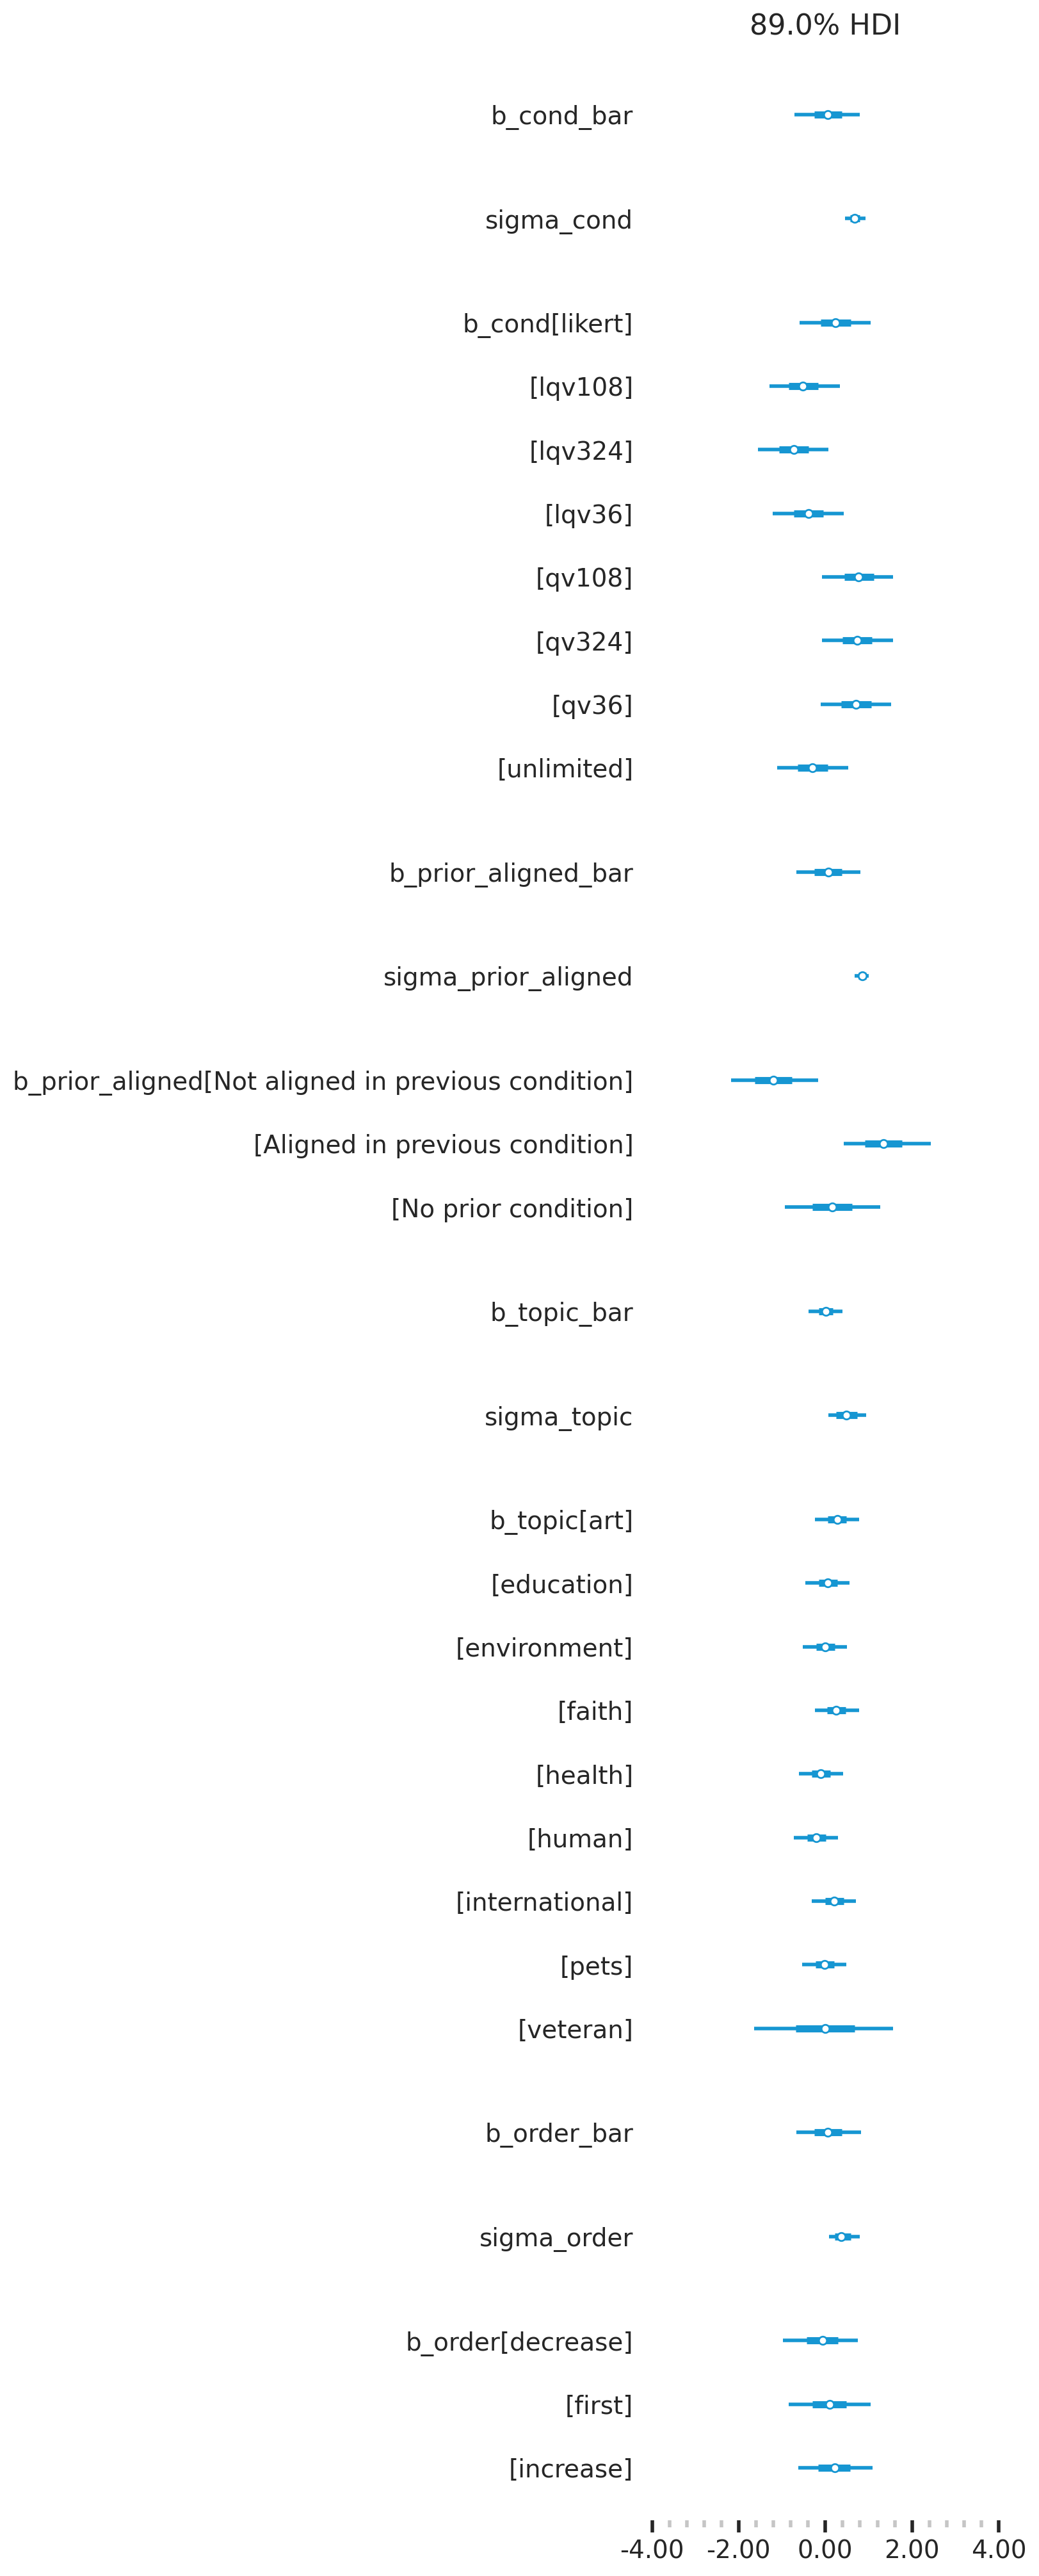

In [ ]:
axs = az.plot_forest(data=model_data,
                     var_names=['b_cond_bar', 'sigma_cond', 'b_cond',
                                'b_prior_aligned_bar', 'sigma_prior_aligned', 'b_prior_aligned',
                                'b_topic_bar', 'sigma_topic', 'b_topic',
                                'b_order_bar', 'sigma_order', 'b_order',
                                ],
                     combined=True,
                     colors=base_color,
                     ridgeplot_alpha=0.3,
                     linewidth=2,
                     figsize=(8, 20))

z = axs[0]
# axs.set_title(Title, size=12)
# z.set_xlabel(r'$\mu$', fontsize=18)  # no individual labels
# z.set_ylabel("Density", fontsize=10)
z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.spines['right'].set_visible(False)
z.spines['top'].set_visible(False)
z.spines['left'].set_visible(False)
z.spines['bottom'].set_visible(False)
z.spines['bottom'].set_position(('outward', 10))
z.xaxis.set_minor_locator(AutoMinorLocator(5))
z.set_xlim(left=-4, right=4)
z.tick_params(which='both', width=2)
z.tick_params(which='major', length=7)
z.tick_params(which='minor', length=4, color=neutral_gray)

# plt.subplots_adjust(hspace=0.75, wspace=0.1)
# plt.savefig('plots/rater_rating_variation.pdf', transparent=False)
plt.show()

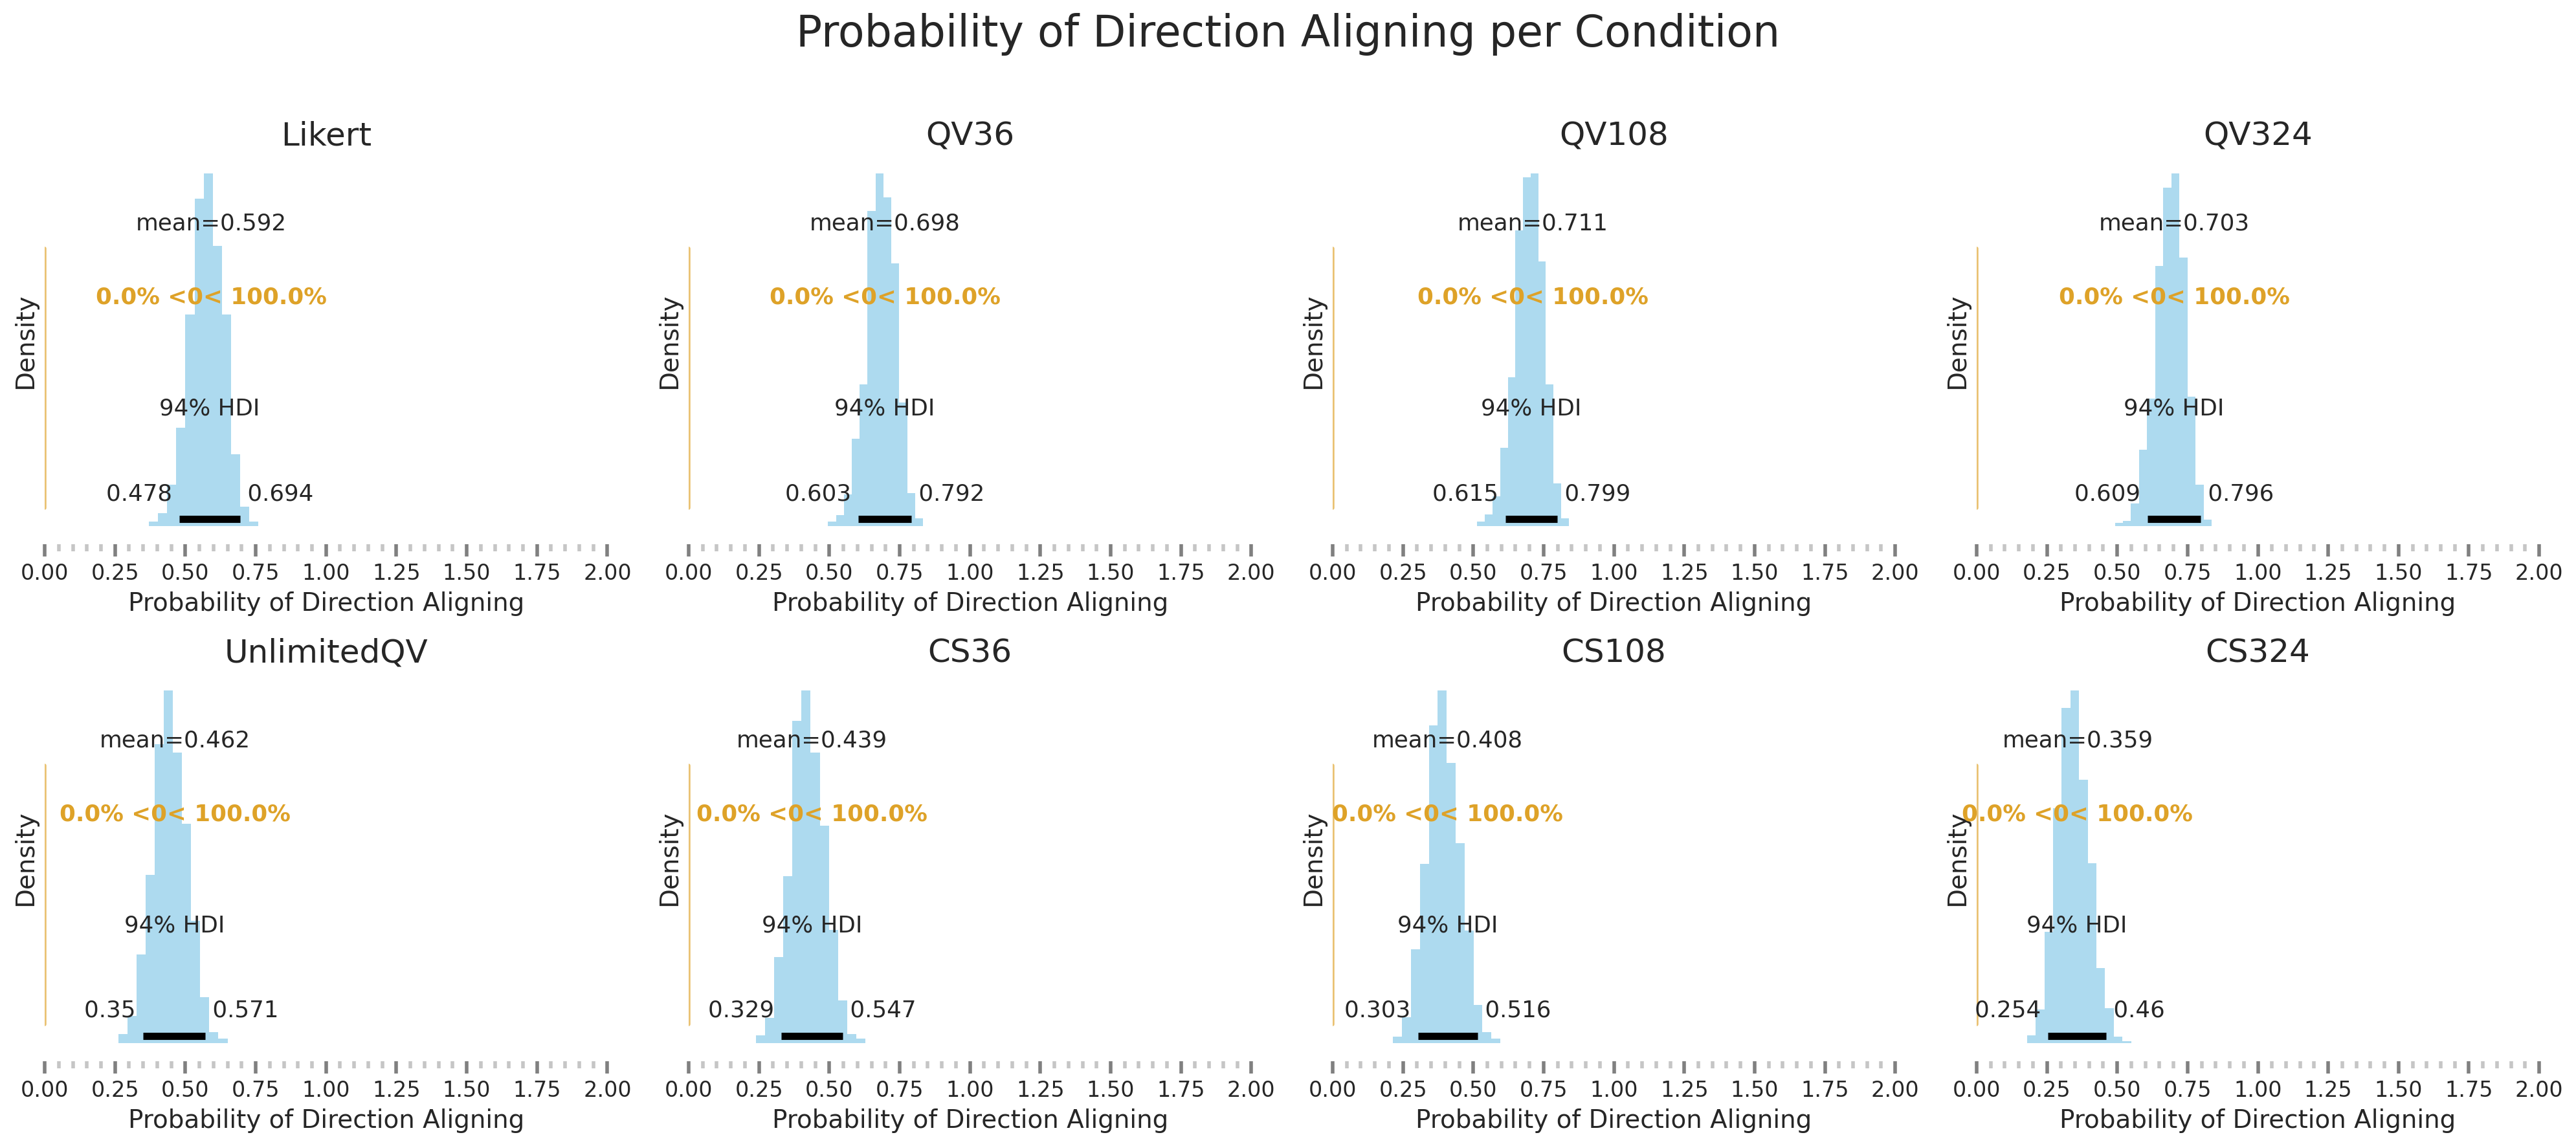

In [ ]:
condition_data = model_data.posterior['b_cond'].mean(("chain"))

likert = condition_data.sel(conditions='likert').values
qv36 = condition_data.sel(conditions='qv36').values
qv108 = condition_data.sel(conditions='qv108').values
qv324 = condition_data.sel(conditions='qv324').values
lqv36 = condition_data.sel(conditions='lqv36').values
lqv108 = condition_data.sel(conditions='lqv108').values
lqv324 = condition_data.sel(conditions='lqv324').values
unlimited = condition_data.sel(conditions='unlimited').values

order_data = model_data.posterior['b_order_bar'].mean(("chain"))
topic_data = model_data.posterior['b_topic_bar'].mean(("chain"))
prior_alignment_data = model_data.posterior['b_prior_aligned_bar'].mean(("chain"))

sum_except_cond = topic_data * 2 + order_data + prior_alignment_data

pred_probs = [
    scipy.special.expit(likert + sum_except_cond),
    scipy.special.expit(qv36 + sum_except_cond),
    scipy.special.expit(qv108 + sum_except_cond),
    scipy.special.expit(qv324 + sum_except_cond),
    scipy.special.expit(unlimited + sum_except_cond),
    scipy.special.expit(lqv36 + sum_except_cond),
    scipy.special.expit(lqv108 + sum_except_cond),
    scipy.special.expit(lqv324 + sum_except_cond),
]


titles = [
    'Likert',
    'QV36',
    'QV108',
    'QV324',
    'UnlimitedQV',
    'CS36',
    'CS108',
    'CS324',
]

row = 2
col = 4
subplot_positions = []

for r in range(row):
  for c in range(col):
    subplot_pos = (r, c)
    subplot_positions.append(subplot_pos)


fig, axes = plt.subplots(row, col, figsize=(20, 9))

for contr, title, subplot_position in zip(pred_probs, titles, subplot_positions):

    z = axes[subplot_position]
    az.plot_posterior(
        contr,
        ax=z,
        textsize=12,
        ref_val=0.0,
        ref_val_color=yellow_color,
        lw=2,
#         alpha=0.3,
        color=base_color,
        hdi_prob=0.94, kind="hist",
#         rope=[0.95, 1.05],
        round_to=3,
#         rope_color=green_color
    )


    z.set_title(title, size=18)
    z.set_xlabel('Probability of Direction Aligning', fontsize=14)
    z.set_ylabel("Density", fontsize=14)
    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.spines['right'].set_visible(False)
    z.spines['top'].set_visible(False)
    z.spines['left'].set_visible(False)
    z.spines['bottom'].set_visible(False)
    z.spines['bottom'].set_position(('outward', 10))
    z.xaxis.set_minor_locator(AutoMinorLocator(5))
#     if subplot_position == (1,1):
    z.set_xlim(left=0, right=2)
    z.tick_params(which='both', width=2)
    z.tick_params(which='major', length=7)
    z.tick_params(which='minor', length=4, color=neutral_gray)

plt.suptitle("Probability of Direction Aligning per Condition\n", size=24)

plt.subplots_adjust(hspace=0.75, wspace=0.1)
plt.tight_layout()

Title = 'Probability_Direction_Alignment_All_Conditions_Def1'
filename = os.path.join(OUTPUT_PATH, Title + '.pdf')
plt.savefig(filename, transparent=False, bbox_inches="tight")
plt.show()

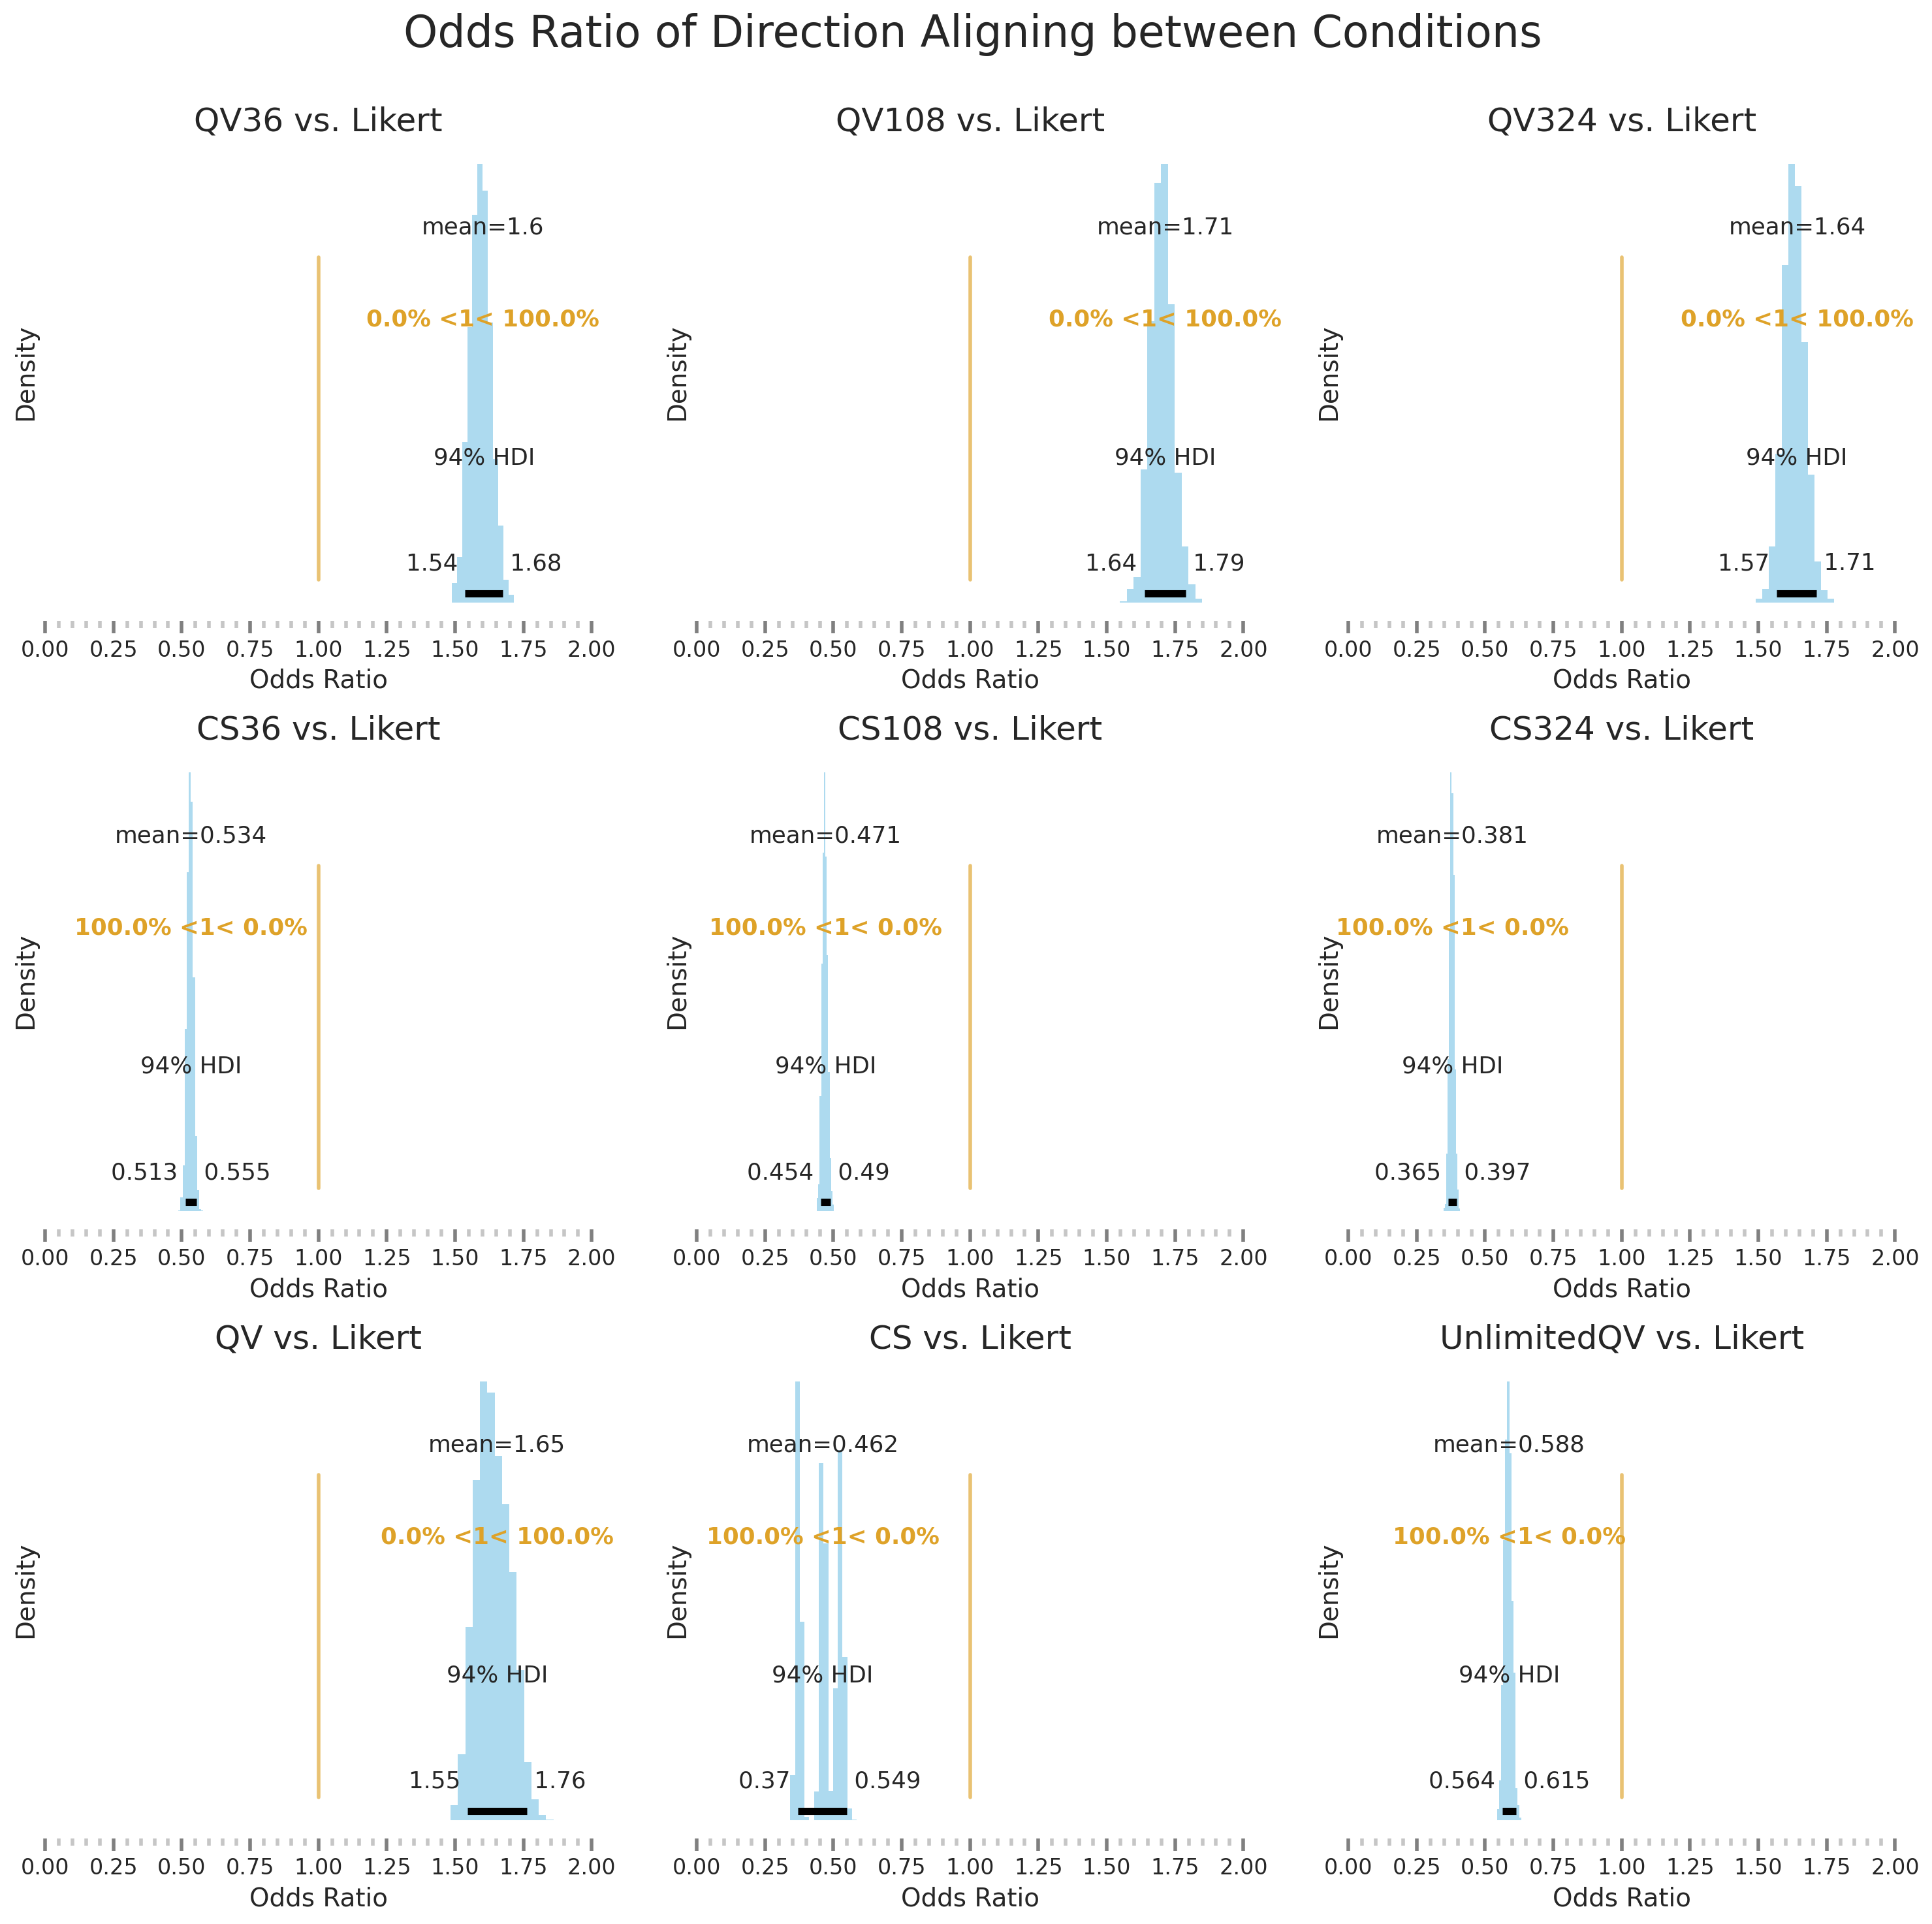

In [ ]:
contrasts = [
    np.exp(qv36 - likert),
    np.exp(qv108 - likert),
    np.exp(qv324 - likert),
    np.exp(lqv36 - likert),
    np.exp(lqv108 - likert),
    np.exp(lqv324 - likert),
    np.concatenate([np.exp(qv36 - likert), np.exp(qv108 - likert), np.exp(qv324 - likert)]),
    np.concatenate([np.exp(lqv36 - likert), np.exp(lqv108 - likert), np.exp(lqv324 - likert)]),
    np.exp(unlimited - likert),
]

titles = [
    'QV36 vs. Likert',
    'QV108 vs. Likert',
    'QV324 vs. Likert',
    'CS36 vs. Likert',
    'CS108 vs. Likert',
    'CS324 vs. Likert',
    'QV vs. Likert',
    'CS vs. Likert',
    'UnlimitedQV vs. Likert',
]

row = 3
col = 3
subplot_positions = []

for r in range(row):
  for c in range(col):
    subplot_pos = (r, c)
    subplot_positions.append(subplot_pos)


fig, axes = plt.subplots(row, col, figsize=(15, 15))

for contr, title, subplot_position in zip(contrasts, titles, subplot_positions):

    z = axes[subplot_position]
    az.plot_posterior(
        contr,
        ax=z,
        textsize=12,
        ref_val=1.0,
        ref_val_color=yellow_color,
        lw=2,
#         alpha=0.3,
        color=base_color,
        hdi_prob=0.94, kind="hist",
#         rope=[0.95, 1.05],
        round_to=3,
#         rope_color=green_color
    )


    z.set_title(title, size=18)
    z.set_xlabel('Odds Ratio', fontsize=14)
    z.set_ylabel("Density", fontsize=14)
    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.spines['right'].set_visible(False)
    z.spines['top'].set_visible(False)
    z.spines['left'].set_visible(False)
    z.spines['bottom'].set_visible(False)
    z.spines['bottom'].set_position(('outward', 10))
    z.xaxis.set_minor_locator(AutoMinorLocator(5))
#     if subplot_position == (1,1):
    z.set_xlim(left=0, right=2)
    z.tick_params(which='both', width=2)
    z.tick_params(which='major', length=7)
    z.tick_params(which='minor', length=4, color=neutral_gray)

plt.suptitle("Odds Ratio of Direction Aligning between Conditions\n", size=24)

plt.subplots_adjust(hspace=0.75, wspace=0.1)
plt.tight_layout()

Title = 'Contrast_Against_Likert_Direction_Alignment_All_Conditions_Def1'
filename = os.path.join(OUTPUT_PATH, Title + '.pdf')
plt.savefig(filename, transparent=False, bbox_inches="tight")
plt.show()

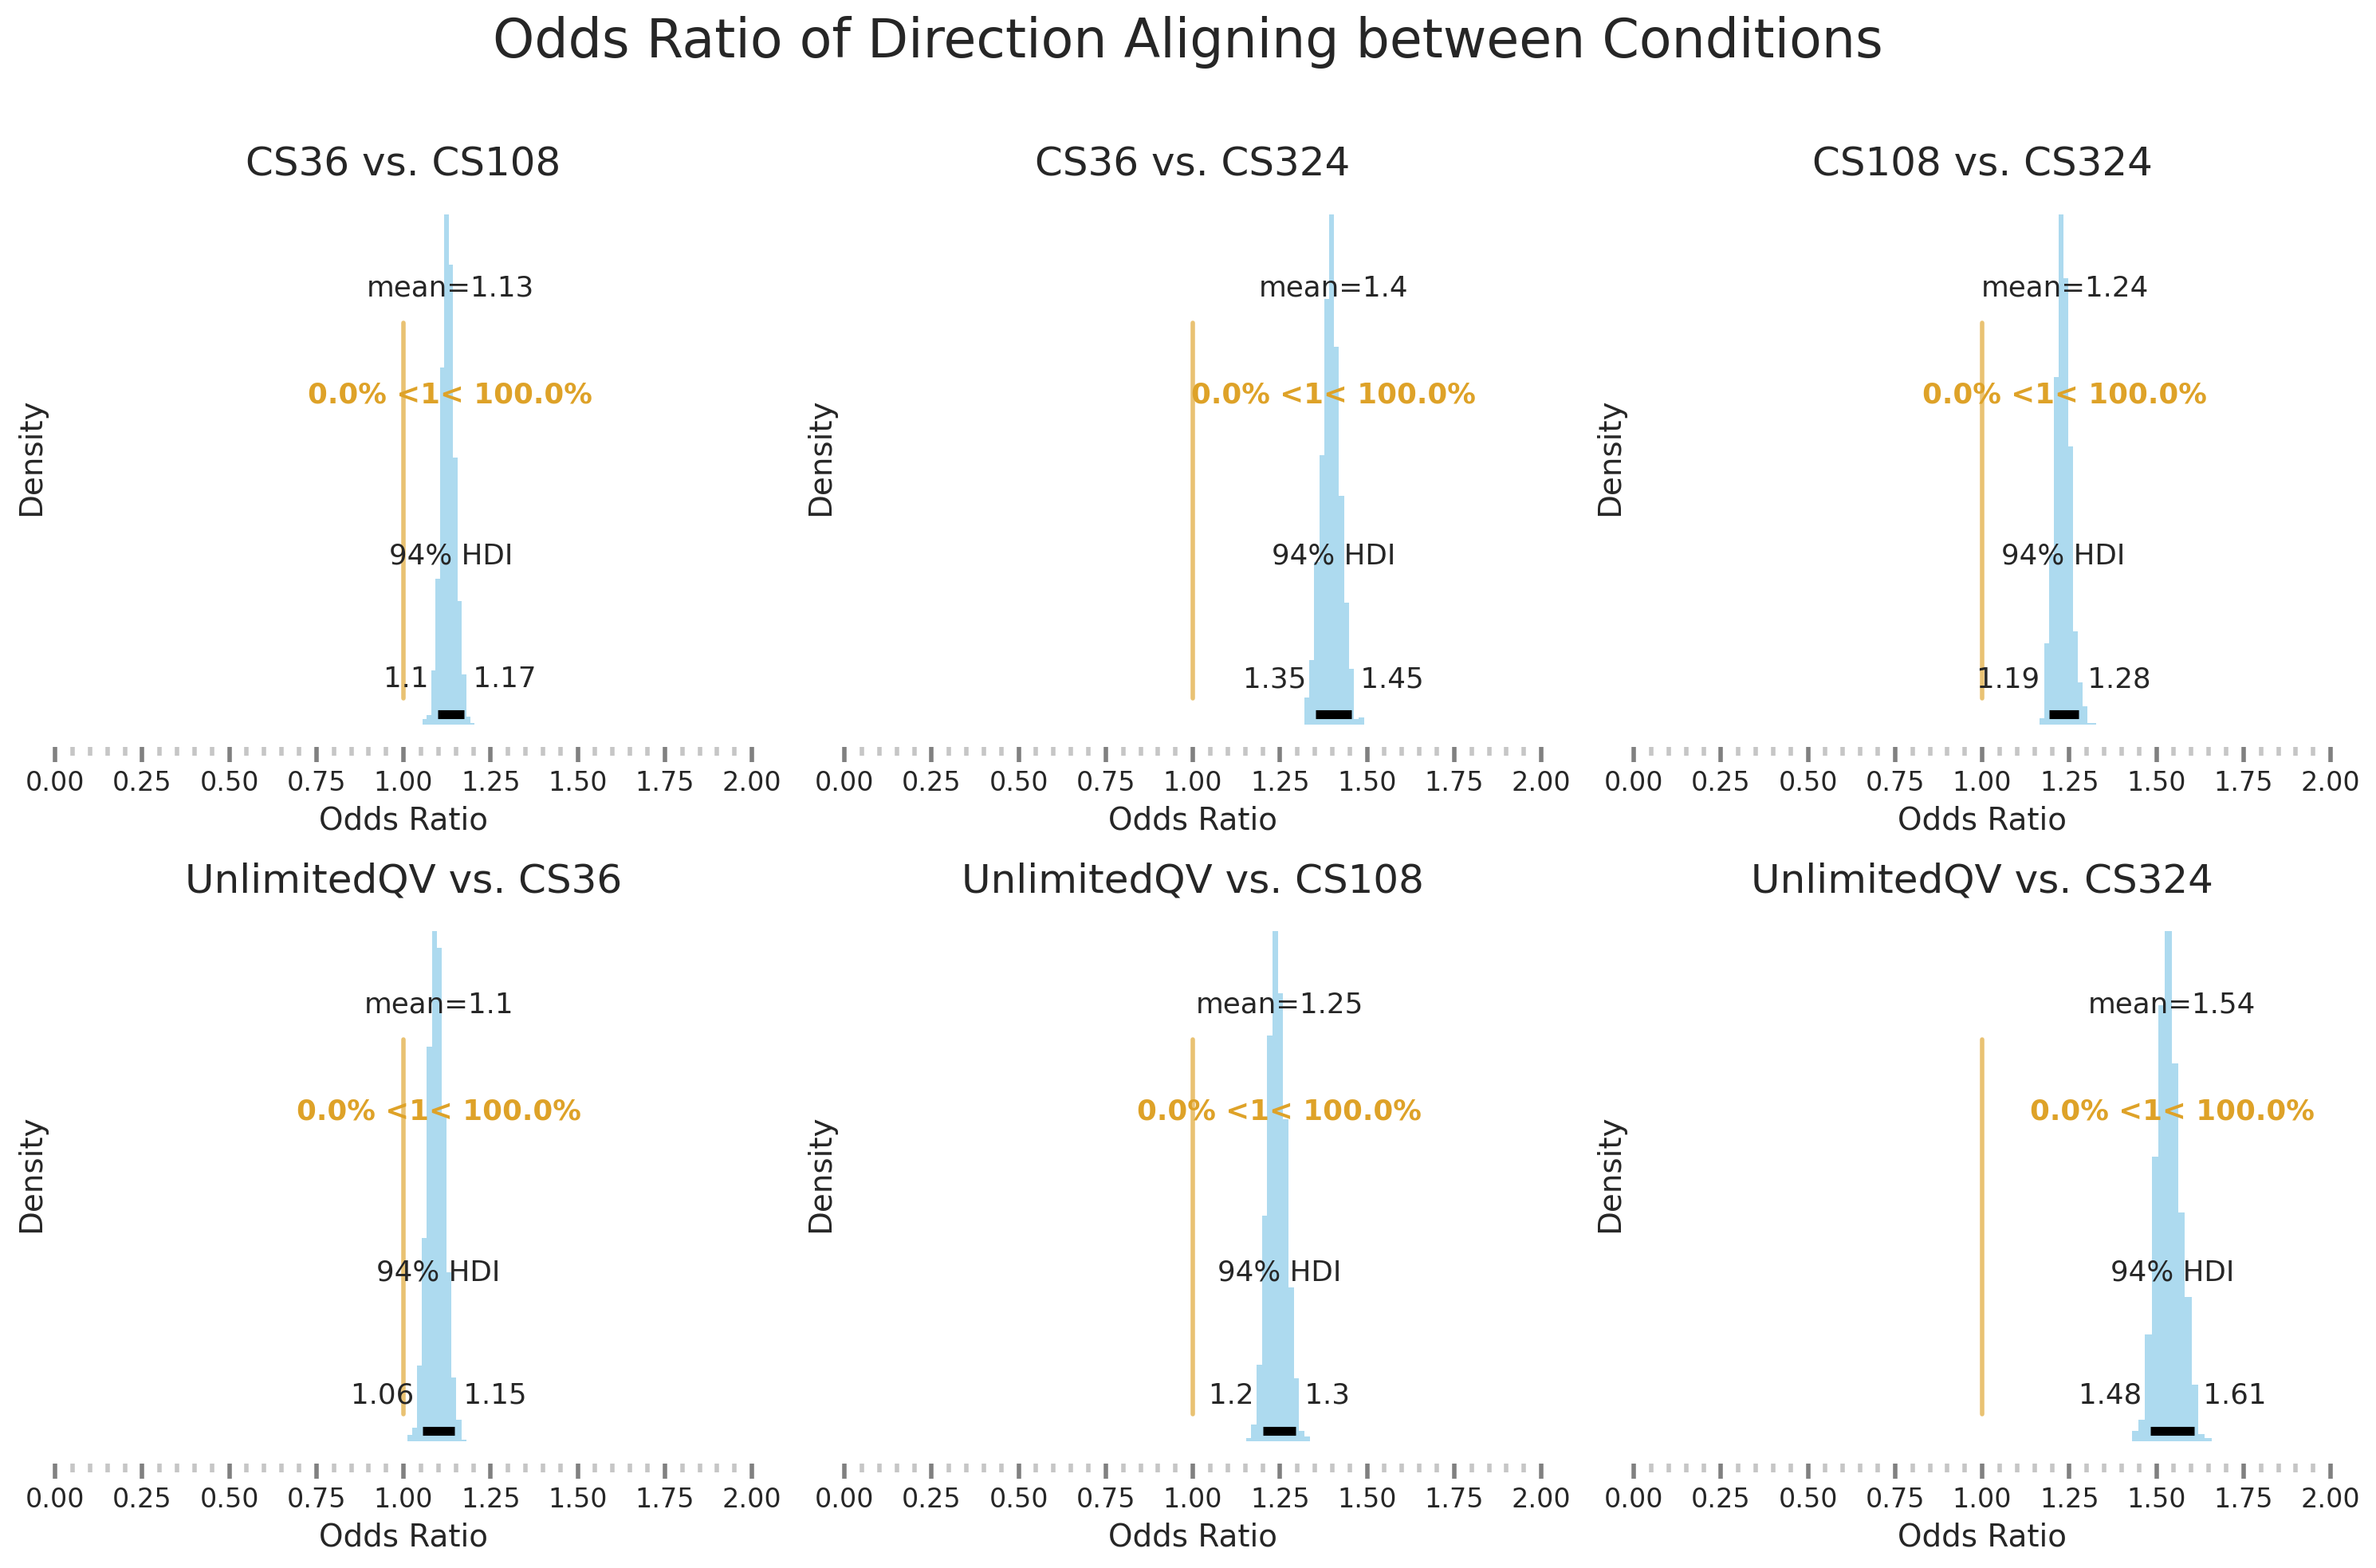

In [ ]:
contrasts = [
    np.exp(lqv36 - lqv108),
    np.exp(lqv36 - lqv324),
    np.exp(lqv108 - lqv324),
    np.exp(unlimited - lqv36),
    np.exp(unlimited - lqv108),
    np.exp(unlimited - lqv324)
]

titles = [
    'CS36 vs. CS108',
    'CS36 vs. CS324',
    'CS108 vs. CS324',
    'UnlimitedQV vs. CS36',
    'UnlimitedQV vs. CS108',
    'UnlimitedQV vs. CS324',
]

row = 2
col = 3
subplot_positions = []

for r in range(row):
  for c in range(col):
    if row == 1:
      subplot_pos = (c,)
    else:
      subplot_pos = (r, c)
    subplot_positions.append(subplot_pos)


fig, axes = plt.subplots(row, col, figsize=(5*col, 5*row))

for contr, title, subplot_position in zip(contrasts, titles, subplot_positions):

    z = axes[subplot_position]
    az.plot_posterior(
        contr,
        ax=z,
        textsize=12,
        ref_val=1.0,
        ref_val_color=yellow_color,
        lw=2,
#         alpha=0.3,
        color=base_color,
        hdi_prob=0.94, kind="hist",
#         rope=[0.95, 1.05],
        round_to=3,
#         rope_color=green_color
    )


    z.set_title(title, size=18)
    z.set_xlabel('Odds Ratio', fontsize=14)
    z.set_ylabel("Density", fontsize=14)
    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.spines['right'].set_visible(False)
    z.spines['top'].set_visible(False)
    z.spines['left'].set_visible(False)
    z.spines['bottom'].set_visible(False)
    z.spines['bottom'].set_position(('outward', 10))
    z.xaxis.set_minor_locator(AutoMinorLocator(5))
#     if subplot_position == (1,1):
    z.set_xlim(left=0, right=2)
    z.tick_params(which='both', width=2)
    z.tick_params(which='major', length=7)
    z.tick_params(which='minor', length=4, color=neutral_gray)

plt.suptitle("Odds Ratio of Direction Aligning between Conditions\n", size=24)

plt.subplots_adjust(hspace=0.75, wspace=0.1)
plt.tight_layout()

Title = 'Contrast_Within_CS_Direction_Alignment_Def1'
filename = os.path.join(OUTPUT_PATH, Title + '.pdf')
plt.savefig(filename, transparent=False, bbox_inches="tight")
plt.show()